# Task 1

In [1]:
import logging
import sys
import os
import pyndri
import pyndri.compat
import collections
from collections import defaultdict
import io
import math
import time
import pickle
import numpy as np
import glob
import os.path
import gc
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import gensim
from gensim.models.lsimodel import LsiModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from scipy import spatial
from scipy.spatial import KDTree
from scipy import stats
from pyflann import FLANN
from scipy.stats import ttest_rel
from sklearn import linear_model, datasets
from sklearn.model_selection import KFold
import re

%matplotlib inline

In [3]:
# NB: rankpy library was modified to make it compatible with Python 3.5
# For this reason, our code for RankPy methods will not run with a default installation using pip
import pyximport
from rankpy.queries import Queries
from rankpy.queries import find_constant_features
from rankpy.models import LambdaMART

ImportError: No module named 'rankpy'

In [2]:
#provided functions

def write_run(model_name, data, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - data: dictionary mapping topic_id to object_assesments;
            object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """
    for subject_id, object_assesments in data.items():
        if not object_assesments:
            logging.warning('Received empty ranking for %s; ignoring.',
                            subject_id)
            
            continue
        
        # Probe types, to make sure everything goes alright.
        # assert isinstance(object_assesments[0][0], float) or \
        #     isinstance(object_assesments[0][0], np.float32)
        assert isinstance(object_assesments[0][1], str) or \
               isinstance(object_assesments[0][1], bytes)
        
        if not skip_sorting:
            object_assesments = sorted(object_assesments, reverse=True)
        
        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]
        
        if isinstance(subject_id, bytes):
            subject_id = subject_id.decode('utf8')
        
        for rank, (relevance, object_id) in enumerate(object_assesments):
            if isinstance(object_id, bytes):
                object_id = object_id.decode('utf8')
            
            out_f.write(
                '{subject} Q0 {object} {rank} {relevance} '
                '{model_name}\n'.format(
                    subject=subject_id,
                    object=object_id,
                    rank=rank + 1,
                    relevance=relevance,
                    model_name=model_name))


def parse_topics(file_or_files,
                 max_topics=sys.maxsize, delimiter=';'):
    assert max_topics >= 0 or max_topics is None

    topics = collections.OrderedDict()

    if not isinstance(file_or_files, list) and \
            not isinstance(file_or_files, tuple):
        if hasattr(file_or_files, '__iter__'):
            file_or_files = list(file_or_files)
        else:
            file_or_files = [file_or_files]

    for f in file_or_files:
        assert isinstance(f, io.IOBase)

        for line in f:
            assert(isinstance(line, str))

            line = line.strip()

            if not line:
                continue

            topic_id, terms = line.split(delimiter, 1)

            if topic_id in topics and (topics[topic_id] != terms):
                    logging.error('Duplicate topic "%s" (%s vs. %s).',
                                  topic_id,
                                  topics[topic_id],
                                  terms)

            topics[topic_id] = terms

            if max_topics > 0 and len(topics) >= max_topics:
                break

    return topics



In [3]:
index = pyndri.Index('index/')

token2id, id2token, _ = index.get_dictionary()

num_documents = index.maximum_document() - index.document_base()

dictionary = pyndri.extract_dictionary(index)

filename = 'data_structure.pickle'

#to avoid computing statistics every time, they are saved and loaded from a pickle file

if os.path.isfile(filename):
    print('Loading from ' + filename)

    (queries,
     tokenized_queries,
     avg_doc_length,
     total_terms,
     query_term_ids,
     document_lengths,
     unique_terms_per_document,
     term_occurr_in_query,
     inverted_index,
     collection_frequencies,
     background_probabilities) = pickle.load(open(filename, 'rb'))

    num_queries = len(tokenized_queries.keys())

    print('Loaded')

else:
    with open('./ap_88_89/topics_title', 'r') as f_topics:
        queries = parse_topics([f_topics])

    # query_id : [query_token_ids]
    tokenized_queries = {query_id: [dictionary.translate_token(token)
                                    for token in index.tokenize(query_string)
                                    if dictionary.has_token(token)]
                         for query_id, query_string in queries.items()}
    num_queries = len(tokenized_queries.keys())

    # query_id -> query_term -> occurrencies
    term_occurr_in_query = collections.defaultdict(int)
    for query_id, query_terms in tokenized_queries.items():
        query_bow = collections.Counter(
            term for term in query_terms
            if term > 0)
        term_occurr_in_query[query_id] = query_bow
        
    # set of terms present in all queries
    query_term_ids = set(
        query_term_id
        for query_term_ids in tokenized_queries.values()
        for query_term_id in query_term_ids)

    print('Gathering statistics about', len(query_term_ids), 'terms.')

    # inverted index creation.

    document_lengths = {}
    unique_terms_per_document = {}

    # query_term_id , int_doc_id -> document_term_frequency
    inverted_index = collections.defaultdict(dict)
    # query_term_id -> occurrencies_in_all_docs
    collection_frequencies = collections.defaultdict(int)
    background_probabilities = collections.defaultdict(float) #background probabilities, 
                                                            #computed as written in the report

    total_terms = 0

    start_time = time.time()

    # int_doc_id [1...maximum_document()]
    # ext_doc_id [APXXXXXX-XXXX]
    for int_doc_id in range(index.document_base(), index.maximum_document()):
        ext_doc_id, doc_token_ids = index.document(int_doc_id)

        # token_id -> token_occurrencies
        document_bow = collections.Counter(
            token_id for token_id in doc_token_ids
            if token_id > 0)
        document_length = sum(document_bow.values())

        document_lengths[int_doc_id] = document_length
        total_terms += document_length

        unique_terms_per_document[int_doc_id] = len(document_bow)

        for query_term_id in query_term_ids:
            assert query_term_id is not None

            document_term_frequency = document_bow.get(query_term_id, 0)

            if document_term_frequency == 0:
                continue

            background_probabilities[query_term_id] += document_term_frequency / document_length
            collection_frequencies[query_term_id] += document_term_frequency
            inverted_index[query_term_id][int_doc_id] = document_term_frequency

    avg_doc_length = total_terms / num_documents

    for query_term_id in background_probabilities.keys():
        background_probabilities[query_term_id] /= num_documents

    print('Inverted index creation took', time.time() - start_time, 'seconds.')

    t = (queries,
         tokenized_queries,
         avg_doc_length,
         total_terms,
         query_term_ids,
         document_lengths,
         unique_terms_per_document,
         term_occurr_in_query,
         inverted_index,
         collection_frequencies,
         background_probabilities)

    pickle.dump(t, open(filename, "wb"))


Loading from data_structure.pickle
Loaded


In [4]:
# Run Retrieval given a score function
def run_retrieval(model_name, score_fn):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.

    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example)
    """
    
    outdir = './rankings'
    
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    
    run_out_path = os.path.join(outdir, '{}.run'.format(model_name))
    
    if os.path.exists(run_out_path):
        return
    
    retrieval_start_time = time.time()
    
    print('Retrieving using', model_name)
    
    data = {}
    counter = 0
    
    # Fill the data dictionary: query_id --> [(document_score, external_doc_id), ... , ( , )]
    for query_id, query_terms in tokenized_queries.items():
        counter += 1
        if counter % 15 == 0 and counter:
            print(model_name + ': ' + str(counter / num_queries * 100) + "% ...")
        
        ranking = []
        
        for int_doc_id in range(index.document_base(), index.maximum_document()):
            ext_doc_id, _ = index.document(int_doc_id)
            
            doc_score = 0
            empty = True
            for query_term_id in query_terms:
                if query_term_id > 0:
                    empty = False
                    document_term_freq = inverted_index[query_term_id][int_doc_id] if int_doc_id in inverted_index[
                        query_term_id] else 0
                    
                    doc_score += score_fn(int_doc_id, query_term_id, document_term_freq)
            if empty:
                doc_score = float('-inf')
            
            ranking.append((doc_score, ext_doc_id))
        
        #to save memory, we keep only the best 1000 documents per query
        data[query_id] = sorted(ranking, key=lambda x: -x[0])[:1000]
        del ranking
        gc.collect()
    
    print("Printing results in '" + model_name + ".run'")
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)
    print('Run retrieval took', time.time() - retrieval_start_time, 'seconds.')
    return data


### TF-IDF

In [8]:
# Compute the tfidf give a doc_id and a query_term_id
def tfidf(int_document_id, query_term_id, document_term_freq):  
    """
    Scoring tfidf for a document and a query term

    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term
    """

    df = len(inverted_index[query_term_id])
    idf = math.log(num_documents) - math.log(df) if df else 0
    tfidf = math.log(1 + document_term_freq) * idf

    return tfidf

### BM-25

In [9]:
def bm25(int_document_id, query_term_id, document_term_freq):
    """
    Scoring bm25 for a document and a query term

    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term
    """

    if int_document_id in document_lengths:
        k1 = 1.2
        b = 0.75
        l_d = document_lengths[int_document_id]
        l_avg = avg_doc_length

        df = len(inverted_index[query_term_id])
        idf = math.log(num_documents) - math.log(df)
        bm25 = (k1 + 1) * document_term_freq * idf / (k1 * ((1 - b) + b * (l_d / l_avg)) + document_term_freq)

        return bm25

    else:
        return 0 #handle documents with length 0

### Language Models

#### Ditichlet Prior

In [10]:
def dirichletPrior(int_document_id, query_term_id, document_term_freq, mu=500):
    """
    Scoring Dirichlet Prior for a document and a query term

    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term
    """
    
    score = np.log(document_term_freq + mu * background_probabilities[query_term_id])
    score -= np.log(document_lengths[int_document_id] + mu)
    
    return score

#### Absolute Discounting

In [11]:
def absoluteDiscounting(int_document_id, query_term_id, document_term_freq, delta=0.1):
    """
    Scoring Absolute Discounting for a document and a query term

    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term
    """
    
    if document_lengths[int_document_id] > 0:
        ad = max(document_term_freq - delta, 0)
        ad += delta * unique_terms_per_document[int_document_id] * background_probabilities[query_term_id]
        ad = np.log(ad)
        ad -= np.log(document_lengths[int_document_id])
        return ad
    else:
        return float('-inf') #handle documents with length 0

#### Jelinek-Mercer

In [12]:
def jm(int_document_id, query_term_id, document_term_freq, lamb=0.1):
    """
    Scoring Jelinek-Mercer for a document and a query term

    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term
    """
    l_d = document_lengths[int_document_id]
    back_prob = background_probabilities[query_term_id]
    
    if l_d:
        prob = document_term_freq / l_d
    else:
        prob = 0 #handle documents with length 0
    
    jm = lamb * prob + (1 - lamb) * back_prob
    
    return np.log(jm)

### Position Language Model

Kernel functions for PBM using sigma = 50

In [5]:
sigma = 50

# kernel functions
def in_sigma_range(i, j):
    return math.fabs(i - j) <= sigma

def gaussian_kernel(i, j):
    return math.exp( (-(i - j) ** 2) / (2 * (sigma ** 2)) )

def triangle_kernel(i, j):
    return 1 - ((i - j) / sigma) if in_sigma_range(i, j) else 0

def cosine_kernel(i, j):
    return 1/2 * (1 +  math.cos(math.pi * math.fabs(i - j) / sigma)) if in_sigma_range(i, j) else 0

def circle_kernel(i, j):
    return math.sqrt(1 - (math.fabs(i - j) / sigma) ** 2) if in_sigma_range(i, j) else 0

def passage_kernel(i, j):
    return 1 if in_sigma_range(i, j) else 0


kernels = {'gaussian': gaussian_kernel, 'triangle': triangle_kernel, 'cosine': cosine_kernel,
       'circle': circle_kernel, 'passage': passage_kernel}

In [16]:
#cdf functions for all kernels, to calculate the normalizing term

def gaussian_cdf(j, mean):
    x = (j - mean) / sigma
    # eq 26.2.16
    p = 0.33267
    a_1 = 0.43618
    a_2 = -0.12016
    a_3 = 0.93729
    t = 1 / (1 + math.fabs(x) * p)
    t = 1 / math.sqrt(2 * math.pi) * math.exp(-0.5 * x * x) * (a_1 * t + a_2 * t ** 2 + a_3 * t ** 3)
    if x >= 0:
        return math.sqrt(2 * math.pi * sigma * sigma) * (1 - t)
    else:
        return math.sqrt(2 * math.pi * sigma * sigma) * t

    
def triangle_cdf(j, mean):
    x = (j - mean) / sigma
    if x < -1:
        return 0
    elif x >= 1:
        return sigma
    elif x < 0:
        return sigma * (1 - math.fabs(x)) ** 2 / 2.0
    else:
        return sigma - sigma * (1 - x) ** 2 / 2.0


def cosine_cdf(j, mean):
    x = (j - mean) / sigma
    if x < -1:
        return 0
    elif x >= 1:
        return sigma
    else:
        return sigma * 0.5 * (1 + x - math.sin(math.pi * x) / math.pi)
    
    
def circle_cdf(j, mean):
    x = (j - mean) / sigma
    if x < -1:
        return 0
    elif x >= 1:
        return sigma
    elif x < 0:
        return sigma * (np.arcsin(x)/ math.pi + 1 * 0.5 + x * np.sqrt(1 - x * x)/ math.pi)
    else:
        return sigma - sigma * (np.arcsin(-x) / math.pi + 1 * 0.5 + x * np.sqrt(1 - x * x)/ math.pi)

def passage_cdf(j, mean):
    res = 0
    x = (j - mean) / sigma
    if x < -1:
        return 0
    elif x >= 1:
        return 2.0 * sigma
    else:
        return sigma + sigma * x


cdf = {'gaussian': gaussian_cdf, 'triangle': triangle_cdf, 'cosine': cosine_cdf,
       'circle': circle_cdf, 'passage': passage_cdf}

#normalization terms are computed in an optimised way, see report
def compute_normalization(position, kernel, doc_len):
    return cdf[kernel](doc_len, position) - cdf[kernel](-1, position)

In [17]:
# instead of computing a score for all positions, to save time 
# find relevant indices for a document and a query, for each kernel
 
def compute_indices(doc_token_ids, query_terms, kernel):
    gaps = {"gaussian": 60, "triangle": 25, "cosine": 25, "circle": 50, "passage": 50}
    gap = gaps[kernel]
    # _, doc_token_ids = index.document(int_document_id)
    
    indices = set()
    min_pos = len(doc_token_ids)
    max_pos = 0
    
    for term in query_terms:
        occurrencies = [i for i, x in enumerate(doc_token_ids) if x == term]
        for o in occurrencies:
            indices.update([i for i in range(max(0, o - gap), min(o + gap + 1, len(doc_token_ids)))])
            if min_pos > o:
                min_pos = o
            if max_pos < o:
                max_pos = o
    
    max_set = set([i for i in range(max_pos + 1, len(doc_token_ids))])
    min_set = set([i for i in range(0, min_pos)])
    
    indices = (indices - max_set) - min_set
    
    return indices

In [18]:
# Compute the score of a document with respect to a list of queries
# It's possible to specify a list of parameteres 'mu'. In this way, the document will receive a different score 
#for each of the parameters.
# The results will be the same as calling multiple times this function with different parameter;
# however, using one unique call, some common computations are exploited to make the process faster.
# returns a dictionary with:
#   - keys: the different values of mu
#   - values: a list of pairs (query_id, score), with the scores of the document w.r.t each of the queries 
#using a particular value of mu

def positionLanguageModel(int_document_id, queries, kernel_name, mu=[500]):
    kernel = kernels[kernel_name]
    
    log_probabilities = {}
    normalizations = {}
    occurrence_indices = {w: [] for w in query_term_ids}
    
    if not isinstance(mu, collections.Iterable):
        mu = [mu]
    
    mu = np.array(list(mu))
    
    ext_doc_id, doc_token_ids = index.document(int_document_id)
    
    doc_token_ids = [d_id for d_id in doc_token_ids if d_id > 0]

    doc_len = len(doc_token_ids)
    
    for i, w in enumerate(doc_token_ids):
        if w in occurrence_indices:
            occurrence_indices[w].append(i)
    
    #store scores to optimise
    def position_logprob(w, i):
        if (w, i) not in log_probabilities:
            norm = compute_normalization(i, kernel_name, doc_len)
            indices = occurrence_indices[w]
            
            p = mu * background_probabilities[w]
            for j in indices:
                p += kernel(i, j)
            
            log_probabilities[(w, i)] = np.log(p) - np.log(norm + mu)
        
        return log_probabilities[(w, i)]
    
    scores = {m: [] for m in mu}
    
    for query_id in queries:
        query_terms = tokenized_queries[query_id]
        
        indeces = compute_indices(doc_token_ids, query_terms, kernel_name)
        
        max_score = float('-inf') * np.ones(len(mu))
        
        for j in indeces:
            
            s = np.zeros(len(mu))
            for w in query_terms:
                s += position_logprob(w, j)
            
            max_score = np.maximum(s, max_score) #Best position strategy
        
        max_score /= len(query_terms)
        
        for i, m in enumerate(mu):
            scores[m].append((query_id, max_score[i]))
    
    return scores

In [19]:
#contains for each document the list of queries (ids) which share at least a word with the document
related_queries = collections.defaultdict(set)

op_count = 0

for query_id, terms_ids in tokenized_queries.items():
    for query_term_id in set(terms_ids):
        if query_term_id > 0:
            for int_doc_id in inverted_index[query_term_id].keys():
                op_count += 1
                related_queries[int_doc_id].add(query_id)

op_count_2 = 0
for doc, queries in related_queries.items():
    op_count_2 += len(queries)

print('total operations\t', op_count)
print('total pairs\t\t', op_count_2)
print('Tot queries:', len(tokenized_queries))
print('Tot docs:', len(document_lengths))
print('Total possible pairs:\t', len(tokenized_queries)*len(document_lengths))
print('Saving:', 1. - op_count_2 /(len(tokenized_queries)*len(document_lengths)))

total operations	 4103294
total pairs		 3568531
Tot queries: 150
Tot docs: 164597
Total possible pairs:	 24689550
Saving: 0.8554639108448716


In [20]:
# use a kernel for a Position Language Model, score all the documents w.r.t. the queries and store 
#the results in a file
#it is possible to use a list of different values for 'mu' to run multiple experiments at the same time
def run_retrieval_PLM(kernel_name, mu=[500, 600, 700, 800, 900]):
    outdir = './rankings'
    
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    
    outfiles = {}
    mu_s = []
    for m in mu:
        model_name = '{}_mu_{}'.format(kernel_name, m)
        run_out_path = os.path.join(outdir, '{}.run'.format(model_name))
        
        if not os.path.exists(run_out_path):
            mu_s.append(m)
            outfiles[m] = (model_name, run_out_path)
    
    mu = mu_s
    
    print('Computing with mu =', mu)
    
    if len(mu) > 0:
        
        data = {m: collections.defaultdict(list) for m in mu}
        
        start_time = time.time()
        for i, (int_document_id, queries) in enumerate(related_queries.items()):
            ext_doc_id, _ = index.document(int_document_id)
            queries_scores = positionLanguageModel(int_document_id, queries, kernel_name, mu=mu)
            for m, scores in queries_scores.items():
                for query_id, score in scores:
                    data[m][query_id].append((score, ext_doc_id))
            
            if i % 20000 == 0:
                print(time.time() - start_time, i / len(related_queries) * 100.0, '%')
        
        
        for m in mu:
            for query_id in tokenized_queries.keys():
                docs_scores = data[m][query_id]
                if len(docs_scores) != len(set([d_id for score, d_id in docs_scores])):
                    print(query_id, 'different lenghts!')
    
    print('Ready to store results to file')
    
    for m in mu:
        
        model_name, run_out_path = outfiles[m]

        print('\tsaving to', run_out_path)

        with open(run_out_path, 'w') as f_out:
            write_run(
                model_name=model_name,
                data=data[m],
                out_f=f_out,
                max_objects_per_query=1000)

## Experiments

In [87]:
run_retrieval('tfidf', tfidf)
run_retrieval('bm25', bm25)

In [21]:
#dirichlet prior
for mu in [100, 500, 1000, 1500, 2000, 2500]:

    exp_start_time = time.time()
    model = lambda int_document_id, query_term_id, document_term_freq, mu=mu: dirichletPrior(int_document_id,
                                                                                             query_term_id,
                                                                                             document_term_freq, mu)
    run_retrieval('dirichletPrior_mu_' + str(mu), model)
    print(mu, 'FINISHED! Time Elapsed:', time.time() - exp_start_time, 'seconds')

100 FINISHED! Time Elapsed: 3.886222839355469e-05 seconds
500 FINISHED! Time Elapsed: 0.00010251998901367188 seconds
1000 FINISHED! Time Elapsed: 0.00012183189392089844 seconds
1500 FINISHED! Time Elapsed: 8.106231689453125e-05 seconds
2000 FINISHED! Time Elapsed: 1.430511474609375e-05 seconds
2500 FINISHED! Time Elapsed: 1.239776611328125e-05 seconds


In [22]:
#jelinek-mercer
for lamb in [0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95]:

    exp_start_time = time.time()
    model = lambda int_document_id, query_term_id, document_term_freq, lamb=lamb: jm(int_document_id,
                                                                                     query_term_id,
                                                                                     document_term_freq, lamb)
    run_retrieval('jm_lamb_' + str(lamb), model)
    print(lamb, 'FINISHED! Time Elapsed:', time.time() - exp_start_time, 'seconds')


0.05 FINISHED! Time Elapsed: 0.00017333030700683594 seconds
0.1 FINISHED! Time Elapsed: 0.0001366138458251953 seconds
0.2 FINISHED! Time Elapsed: 0.0002713203430175781 seconds
0.5 FINISHED! Time Elapsed: 0.00015044212341308594 seconds
0.8 FINISHED! Time Elapsed: 0.00018978118896484375 seconds
0.9 FINISHED! Time Elapsed: 0.00013780593872070312 seconds
0.95 FINISHED! Time Elapsed: 0.000133514404296875 seconds


In [24]:
#absolute discount
for delta in [0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95]:

    exp_start_time = time.time()
    model = lambda int_document_id, query_term_id, document_term_freq, delta=delta: absoluteDiscounting(
        int_document_id, query_term_id, document_term_freq, delta)
    run_retrieval('absoluteDiscounting_delta_' + str(delta), model)
    print(delta, 'FINISHED! Time Elapsed:', time.time() - exp_start_time, 'seconds')

0.05 FINISHED! Time Elapsed: 7.987022399902344e-05 seconds
0.1 FINISHED! Time Elapsed: 0.00013065338134765625 seconds
0.2 FINISHED! Time Elapsed: 1.4543533325195312e-05 seconds
0.5 FINISHED! Time Elapsed: 1.3589859008789062e-05 seconds
0.8 FINISHED! Time Elapsed: 1.3828277587890625e-05 seconds
0.9 FINISHED! Time Elapsed: 1.33514404296875e-05 seconds
0.95 FINISHED! Time Elapsed: 1.33514404296875e-05 seconds
EVERYTHING FINISHED!!!! Total Time Elapsed: 0.0002586841583251953 seconds


In [25]:
#PLM for all kernels
start_time = time.time()

for kernel_name in kernels.keys():
    kernel_start_time = time.time()
    print('USING KERNEL', kernel_name)

    run_retrieval_PLM(kernel_name)

    print(kernel_name, 'FINISHED! Time Elapsed:', time.time() - kernel_start_time, 'seconds')

end_time = time.time()

print('FINISHED! Time Elapsed:', end_time - start_time, 'seconds')


USING KERNEL circle
Computing with mu = []
Ready to store results to file
circle FINISHED! Time Elapsed: 0.00042891502380371094 seconds
USING KERNEL passage
Computing with mu = []
Ready to store results to file
passage FINISHED! Time Elapsed: 0.0003306865692138672 seconds
USING KERNEL cosine
Computing with mu = []
Ready to store results to file
cosine FINISHED! Time Elapsed: 0.0002086162567138672 seconds
USING KERNEL triangle
Computing with mu = []
Ready to store results to file
triangle FINISHED! Time Elapsed: 0.0003490447998046875 seconds
USING KERNEL gaussian
Computing with mu = []
Ready to store results to file
gaussian FINISHED! Time Elapsed: 0.0003998279571533203 seconds
FINISHED! Time Elapsed: 0.002690553665161133 seconds


In [109]:
# read first 1000 documents for each query as ranked by tfidf to reduce computation time in following tasks
ext_2_int = {}
for int_doc_id in range(index.document_base(), index.maximum_document()):
        ext_doc_id, doc_token_ids = index.document(int_doc_id)
        ext_2_int[ext_doc_id] = int_doc_id

first_1000_dict = collections.defaultdict(set)
with open("./rankings/tfidf.run", "r") as f:
    for line in f.readlines():
        query_id, _, ext_doc_id, _, _ , _ = line.split(" ")
        int_doc_id = ext_2_int[ext_doc_id]
        first_1000_dict[query_id].add(ext_doc_id)

## Analysis

In [ ]:
# trec evaluation of results
subprocess.call("./eval.sh")

In [6]:
task_1 = list(kernels.keys()) + ['tfidf', 'bm25', 'jm', 'dirichletPrior', 'absoluteDiscounting']

In [2]:
# pandas dataframe to store results
def overallPerformances(models, directory):

    performances = collections.defaultdict(dict)

    for filename in glob.glob(os.path.join("./", directory, "*.all")):
        model = os.path.splitext(os.path.basename(filename))[0]
        
        model_name = model.split('_')[0]
        
        if model_name in models:
        
            if '_' in model:
                parameter_name, parameter_value = model.split('_')[1:]
            else:
                parameter_name, parameter_value = '', -1
            parameter_value = float(parameter_value)
        
        
            with open(filename, 'r') as f:
                for line in f:
                    line = line.split()

                    measure = line[0]
                    val = float(line[2])
                    performances[(model_name, parameter_name, parameter_value)][measure] = val


    performances = pd.DataFrame.from_dict(performances, orient='index')
    performances.index.rename(['model', 'parameter', 'parameter_value'], inplace=True)
    
    best_ndcg = performances.iloc[performances.reset_index().groupby(['model', 'parameter'])['ndcg_cut_10'].idxmax()].copy()
    
    return performances, best_ndcg

In [8]:
performances, best_ndcg = overallPerformances(task_1, 'evaluations')

In [9]:
#parameters values that give best result on evaluation set
best_ndcg

,,,map_cut_1000,recall_1000,ndcg_cut_10,P_5
model,parameter,parameter_value,,,,
absoluteDiscounting,delta,0.8,0.2337,0.6708,0.3966,0.4000
bm25,,-1.0,0.2410,0.6621,0.3987,0.3933
circle,mu,300.0,0.2281,0.6163,0.3807,0.3933
cosine,mu,100.0,0.2257,0.6033,0.3811,0.3933
dirichletPrior,mu,500.0,0.2391,0.6285,0.4030,0.4000
gaussian,mu,100.0,0.2299,0.6140,0.3871,0.3667
jm,lamb,0.2,0.2265,0.6311,0.4022,0.3733
passage,mu,400.0,0.2309,0.6199,0.3884,0.4133
tfidf,,-1.0,0.2403,0.6712,0.3672,0.3667


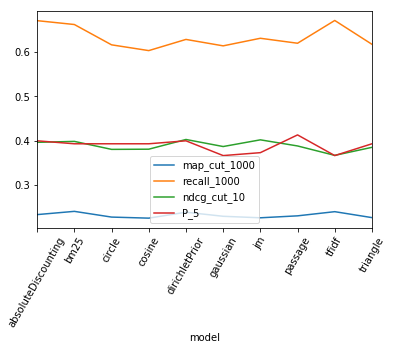

In [10]:
# x axis = model name, y axis = values for all 4 measures with the best scoring parameters
best_ndcg_plot = best_ndcg.copy()
best_ndcg_plot.index = best_ndcg_plot.index.droplevel([1, 2])
#best_ndcg_plot = best_ndcg_plot.reset_index().drop(['parameter', 'parameter_value'], axis=1).set_index('model')
for col in performances:
    best_ndcg_plot[col].plot()
plt.xticks(rotation=60)
plt.legend()
plt.show()

In [3]:
# pandas dataframe to store the single query performance
def queriesPerfomrmances(models, directory):
    query_performances = collections.defaultdict(dict)

    for filename in glob.glob(os.path.join("./", directory, "*.eval")):

        tmp = os.path.basename(filename).split('.')

        model = '.'.join(tmp[:-2])
        measure = tmp[-2]
        
        model_name = model.split('_')[0]
        if model_name in models:
            if '_' in model:
                parameter_name, parameter_value = model.split('_')[1:]
            else:
                parameter_name, parameter_value = '', -1

            parameter_value = float(parameter_value)

            with open(filename, 'r') as f:
                for line in f:
                    line = line.split()

                    query_id = line[1]
                    val = float(line[2])

                    if query_id != 'all':
                        query_id = int(query_id)
                        query_performances[(model_name, parameter_name, parameter_value, query_id)][measure] = val

    query_performances = pd.DataFrame.from_dict(query_performances, orient='index')
    query_performances.index.rename(['model_name', 'parameter_name', 'parameter_value', 'query_id'], inplace=True)
    query_performances.sort_index(inplace=True)
    
    return query_performances

In [12]:
query_performances = queriesPerfomrmances(task_1, 'test')

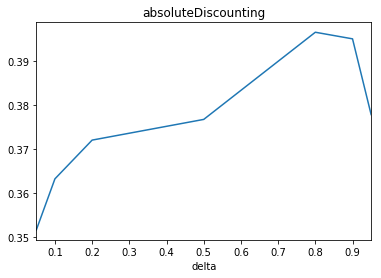

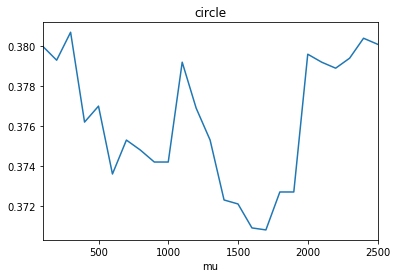

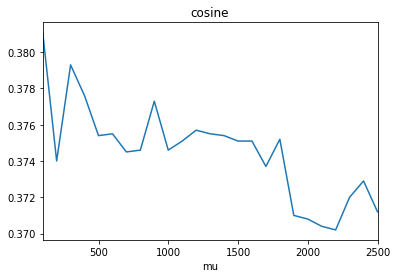

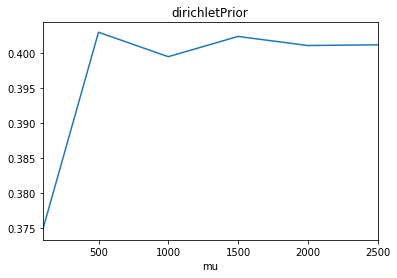

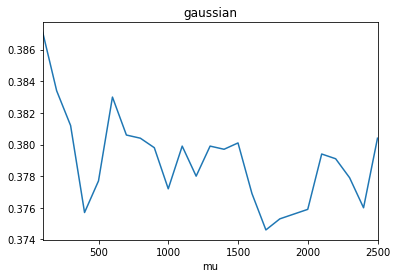

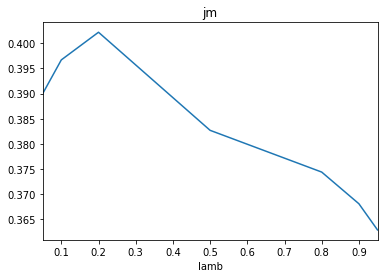

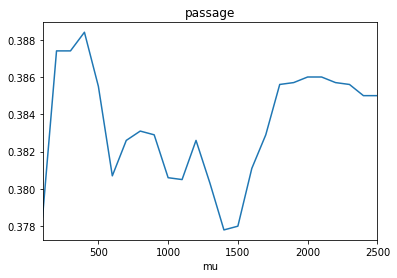

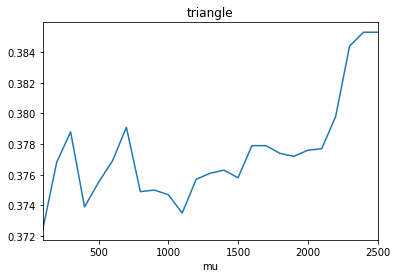

In [13]:
# ndcg@10 for different values of parameters on evaluation set
for ind, _ in performances.groupby(level=[0,1]):
    if ind[1] != '':
        plt.subplots(figsize=(6, 4))
        ax =performances.loc[ind]['ndcg_cut_10'].plot()
        ax.set_xlabel(ind[1])
        ax.set_title(ind[0])

In [49]:
#one sided t-test on test set

def perform_test(model_names, query_performances, best_ndcg, measures=None):
    
    #stat test on models, model_names is a list of strings
    #assuming everything is already in performances
    #returns pandas df with nice colors
    
    
    if measures is None:
        #by default we use all the 4 measures
        alpha = 0.0125  #bonferroni correction 0.05/4 = 0.0125
    else:
        #in case we want to consider a different number of measures
        alpha = 0.05 / len(measures)
        
    def compare_to_alpha(t_statistic, p_value):
        
        if t_statistic > 0 and (p_value/2) < alpha: #p_value/2 for one sided t-test
            return 1.0
        else: 
            return 0
    
    first_model_to_score = {}
    indexes = []
    for index1, _ in best_ndcg.iterrows(): 

        #if index1 in query_performances.index:
        if index1[0] in model_names:
            indexes.append(index1)
            scores = []
            for index2, _ in  best_ndcg.iterrows(): 
                #if index2 in query_performances.index:
                if index2[0] in model_names:
                    if index2 != index1:
                        wins = 0
                        losses = 0
                        for measure in query_performances:
                            if measures is None or measure in measures:
                                sample_1 = query_performances.loc[index1][measure]
                                sample_2 = query_performances.loc[index2][measure]
                                t_statistic, p_value = ttest_rel(sample_2, sample_1) 
                                #if t-statistic > 0 and p_value/2 < alpha, the mean of the first sample is statistically
                                # bigger than the one of the second sample

                                wins += compare_to_alpha(t_statistic, p_value)
                                losses += compare_to_alpha(-t_statistic, p_value)
                        if measures is None:
                            wins /= 4.0
                            losses /= 4.0
                        else:
                            wins /= len(measures)
                            losses /= len(measures)
                        scores.append(wins - losses) 
                    else:
                        scores.append('-')
                first_model_to_score[index1] = scores
    indexes = pd.MultiIndex.from_tuples(indexes)
    stat_test = pd.DataFrame(first_model_to_score, index = indexes)
    
    def colour_table(val):
        if val != '-' and val < 0:
            return 'background-color: red'
        if val == 0:
            return 'background-color: yellow'
        if  val != '-' and val > 0:
            return'background-color: green'
        if val == '-':
            return ''
        else:
            return'background-color: yellow'
    stat_test_col = stat_test.style.applymap(colour_table)
    
    return stat_test_col

In [15]:
#The number in a cell represents the difference between the  
#percentage of wins and losses over the 4 measures (on the one-sided t-test) 
#of the model in the row against the one in the column

# 0 = not enough statistical relevance to reject null hypothesis
# positive value = statistically higher, negative value = statistically lower

perform_test(task_1, query_performances, best_ndcg)

,,,absoluteDiscounting,bm25,circle,cosine,dirichletPrior,gaussian,jm,passage,tfidf,triangle
,,,delta,,mu,mu,mu,mu,lamb,mu,,mu
,,,0.8,-1.0,300.0,100.0,500.0,100.0,0.2,400.0,-1.0,2400.0
absoluteDiscounting,delta,0.8,-,-0.5,0.5,0.5,0,0,0.75,0.25,-0.25,0.75
bm25,,-1.0,0.5,-,0.75,0.75,0.25,0.5,1,0.5,0,1
circle,mu,300.0,-0.5,-0.75,-,0.25,-0.75,-0.5,-0.25,-0.25,-1,0
cosine,mu,100.0,-0.5,-0.75,-0.25,-,-0.5,-0.5,-0.25,-0.25,-0.75,0
dirichletPrior,mu,500.0,0,-0.25,0.75,0.5,-,0.25,0.75,0.5,-0.25,0.75
gaussian,mu,100.0,0,-0.5,0.5,0.5,-0.25,-,0,0,-0.5,0.25
jm,lamb,0.2,-0.75,-1,0.25,0.25,-0.75,0,-,0,-1,0
passage,mu,400.0,-0.25,-0.5,0.25,0.25,-0.5,0,0,-,-0.5,0


In [21]:
perform_test(kernels.keys(), query_performances, best_ndcg)

,,,circle,cosine,gaussian,passage,triangle
,,,mu,mu,mu,mu,mu
,,,300.0,100.0,100.0,400.0,2400.0
circle,mu,300.0,-,0.25,-0.5,-0.25,0
cosine,mu,100.0,-0.25,-,-0.5,-0.25,0
gaussian,mu,100.0,0.5,0.5,-,0,0.25
passage,mu,400.0,0.25,0.25,0,-,0
triangle,mu,2400.0,0,0,-0.25,0,-


In [16]:
test_performances, _ = overallPerformances(task_1, 'test')

test_performances.loc[best_ndcg.index].style.background_gradient(cmap='viridis', low=.6, high=0, axis=0)

,,,map_cut_1000,recall_1000,ndcg_cut_10,P_5
model,parameter,parameter_value,,,,
absoluteDiscounting,delta,0.8,0.2064,0.6358,0.3955,0.3967
bm25,,-1.0,0.2179,0.6548,0.4105,0.4167
circle,mu,300.0,0.1923,0.6125,0.3721,0.385
cosine,mu,100.0,0.1854,0.6134,0.3752,0.3933
dirichletPrior,mu,500.0,0.2098,0.6266,0.4096,0.4183
gaussian,mu,100.0,0.1978,0.6247,0.3896,0.3933
jm,lamb,0.2,0.1952,0.6263,0.367,0.3667
passage,mu,400.0,0.1974,0.6199,0.3827,0.3883
tfidf,,-1.0,0.2155,0.651,0.4169,0.4317


word: oil, pos: [11, 38, 74, 92, 136, 259, 269, 297, 347, 387, 404, 416, 424, 436, 443], score: 7.939405764637841
word: spill, pos: [12, 39, 58, 63, 75, 93, 189, 241, 255, 292, 316, 360, 444], score: 12.75178612721093
word: cleanup, pos: [20, 76, 80, 104, 115, 122, 140, 228, 250, 343], score: 11.481025838646389
plm: -5.995112145876877
tfidf: 32.17221773049516
['oil', 'spill', 'cleanup']


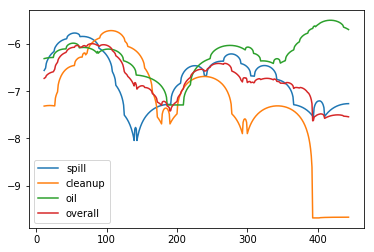

word: cleanup, pos: [3, 20, 61, 74, 175, 252, 264, 314, 375, 388, 391, 394, 419], score: 12.635700038568634
plm: -6.22307028588594
tfidf: 32.14501833057931
['oil', 'spill', 'cleanup']


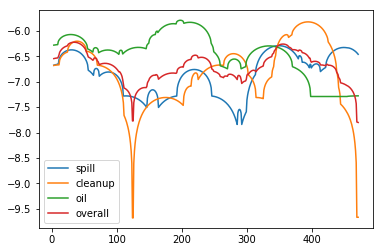

word: cleanup, pos: [77, 246, 289, 369, 441, 525, 572], score: 9.956282219998501
plm: -6.3741809681926505
tfidf: 30.519997519087426
['oil', 'spill', 'cleanup']


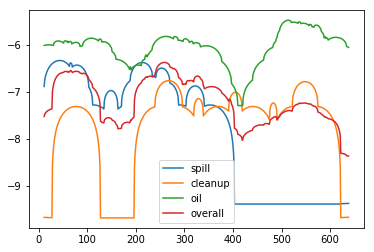

word: cleanup, pos: [5, 36, 90, 214, 234, 241, 273, 293, 384, 391, 393, 413, 436], score: 12.635700038568634
plm: -6.245152500028343
tfidf: 31.106493133913347
['oil', 'spill', 'cleanup']


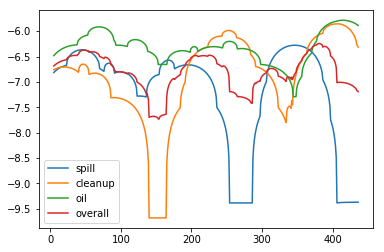

In [114]:
# compare tfidf and plm with circle kernel on a single query

def plm_queries_analysis(int_document_id, queries, kernel_name, mu=[1600]):
    
    index_for_plot = []
    word2PLMscores = defaultdict(list)
    pos_scores = []
    kernel = kernels[kernel_name]
    
    log_probabilities = {}
    normalizations = {}
    occurrence_indices = {w: [] for w in query_term_ids}
    # print(query_term_ids)
    # print(occurrence_indices.keys())
    
    if not isinstance(mu, collections.Iterable):
        mu = [mu]
    
    mu = np.array(list(mu))
    
    ext_doc_id, doc_token_ids = index.document(int_document_id)
    
    doc_token_ids = [d_id for d_id in doc_token_ids if d_id > 0]

    # TODO - considering also stopwords makes the document longer.
    # On the other hand, is dropping stop words right?.
    # choose what to do
    
    doc_len = len(doc_token_ids)  # document_lengths[int_document_id]
    
    for i, w in enumerate(doc_token_ids):
        if w in occurrence_indices:
            occurrence_indices[w].append(i)
    
    def position_logprob(w, i):
        if (w, i) not in log_probabilities:
            norm = compute_normalization(i, kernel_name, doc_len)
            indices = occurrence_indices[w]
            
            p = mu * background_probabilities[w]
            for j in indices:
                p += kernel(i, j)
            
            if norm <= 0:
                print('index:', i, 'unnormalized score', p, 'normalization value:', norm)
            
            log_probabilities[(w, i)] = np.log(p) - np.log(norm + mu)
        
        return log_probabilities[(w, i)]
    
    scores = {m: [] for m in mu}
    
    for query_id in queries:
        query_terms = tokenized_queries[query_id]
        
        indeces = compute_indices(doc_token_ids, query_terms, kernel_name)
        
        max_score = float('-inf') * np.ones(len(mu))
        
        for j in indeces:
            
            index_for_plot.append(j)
            s = np.zeros(len(mu))
            for w in query_terms:
                
                word2PLMscores[w].append(position_logprob(w, j))
                s += position_logprob(w, j)
            pos_scores.append(s/len(query_terms))
            max_score = np.maximum(s, max_score)  # max(s, max_score)
        
        max_score /= len(query_terms)
        
        for i, m in enumerate(mu):
            scores[m].append((query_id, max_score[i]))
    
    return scores, index_for_plot, word2PLMscores, pos_scores, occurrence_indices

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

def compare_circle_tfidf(query_id, tf_lim = 5, cir_lim = -8.36):
    
    rel_docs_list = []                
    for key, cont in mapping[str(query_id)].items():
        if cont == 1:
            ext_doc, _ = index.document(key)
            rel_docs_list.append(ext_doc)
    
    query_ids = tokenized_queries[str(query_id)]
    
    for ext_doc_id in rel_docs_list:
        int_id =  ext_2_int[ext_doc_id]
        _, doc_token_ids = index.document(int_id)
        
        scores, index_for_plot, word2PLMscores, pos_scores, occurrence_indices = plm_queries_analysis(int_id, [str(query_id)], 'circle', mu=[1100])
        
        scores_tf = []
        for query_term_id in query_ids:
           
            document_term_freq = inverted_index[query_term_id][int_id] if int_id in inverted_index[
                                query_term_id] else 0
            score_tf = tfidf(int_id, query_term_id, document_term_freq)
            scores_tf.append(score_tf)
        score_tf_tot = sum(scores_tf)
        
        condition = scores[1100][0][1] > cir_lim or score_tf_tot > tf_lim
        if condition:

            print('plm: {}'.format(scores[1100][0][1]))
            print('tfidf: {}'.format(score_tf_tot))
           
           
            for i, word_id in enumerate(query_ids):
                if len(occurrence_indices[word_id]) > 0:
           
                    print('{}, tf: {}, tf-idf score: {}'.format(id2token[word_id], len( occurrence_indices[word_id]), scores_tf[i]))
                plt.plot(index_for_plot, word2PLMscores[word_id], label=id2token[word_id], color = colors[i])
          
                for xc in occurrence_indices[word_id]:
                    plt.axvline(x=xc, lw = 0.5, color = colors[i])
            plt.plot(index_for_plot, pos_scores, label='overall', color = colors[-1])
            plt.title('Query {}, Doc {}'.format(query_id, ext_doc_id))
            plt.legend()

            plt.show() 

compare_circle_tfidf(182, tf_lim=10, cir_lim=-7.5)
ompare_circle_tfidf(103, tf_lim=16)

# Task 2

In [ ]:
# Generate from the corpus the datastructure [[(terms_in_doc_i, term_occurrencies)] ... for each document]
# This is used to initialize the LSMs.
# Other initializing options we tried substituted occurrencies for each term with presence (1 or 0) or TF-IDF

def generate_corpus():
    
    filename_corpus = 'my_corpus.pickle'

    if os.path.isfile(filename_corpus):
        print('Loading Corpus from ' + filename_corpus)
        my_corpus = pickle.load(open(filename_corpus, 'rb'))
        print('Loaded')

    else:
        my_corpus = []
        print("Generating corpus")

        for int_doc_id in range(index.document_base(), index.maximum_document()):
            _, doc_token_ids = index.document(int_doc_id)
            document_text = []
            for token_id in set(doc_token_ids):
                if token_id > 0:
                    document_text.append((token_id, doc_token_ids.count(token_id)))

            if len(document_text):
                my_corpus.append(document_text)
                
        pickle.dump(my_corpus, open(filename_corpus, "wb"))
            
    return my_corpus

In [ ]:
# Generate LSI Model with k topics from a corpus (if provided)

def generate_lsi(k=100, my_corpus=None):

    filename_lsi = 'lsi_model' + str(k) + '.pickle'

    if os.path.isfile(filename_lsi):
        print('Loading LsiModel from ' + filename_lsi)
        lsi = pickle.load(open(filename_lsi, 'rb'))
        print('Loaded')

    else:
        start_time = time.time()
        N_TOPICS = k
        N_ITER = 2
        
        if my_corpus is None:
            my_corpus = generate_corpus()

        print("Building LsiModel...")
        lsi = LsiModel(id2word=id2token, corpus=my_corpus, num_topics=N_TOPICS, power_iters=N_ITER)
        print("LsiModel created, total time: ", time.time() - start_time)

#         pickle.dump(lsi, open(filename_lsi, "wb"))
    
    return lsi

In [ ]:
# Generate LDA Model with k topics from a corpus (if provided)

def generate_lda(k=100, my_corpus=None):
    
    filename_lda = 'lda_model' + str(k) + '.pickle'

    if os.path.isfile(filename_lda):
        print('Loading LdaModel from ' + filename_lda)
        lda = pickle.load(open(filename_lda, 'rb'))
        print('Loaded')

    else:
        start_time = time.time()
        N_TOPICS = k
        MIN_PROB = 0

        if my_corpus is None:
            my_corpus = generate_corpus()

        print("Building LdaModel...")
        lda = LdaMulticore(my_corpus, id2word=id2token, num_topics=N_TOPICS, workers=3, minimum_probability=MIN_PROB)
        print("LdaModel created, total time: ", time.time() - start_time)

#         pickle.dump(lda, open(filename_lda, "wb"))
        
    return lda

In [ ]:
# fix lists in which some weight for topics are missing (e.g. weight = 0)
def fix_lists(q, d):
    zero = np.finfo(np.float32).tiny
    q_values = []
    d_values = []
    for i in range(max(len(d), len(q))):
        temp_d = [value for idx, value in d if idx == i]
        temp_q = [value for idx, value in q if idx == i]
        if(len(temp_q) == 0):
            q_values.append(zero)
        else:
            q_values.append(temp_q[0])
        if(len(temp_d) == 0):
            d_values.append(zero)
        else:
            d_values.append(temp_d[0])

    return q_values, d_values

# Compute cosine similarity between two lists returned by Gensim LSI or LDA
def cosine_similarity(q, d):
    #if not, terms in q or d are not in the dictionary
    assert len(q) > 0
    assert len(d) > 0
    
    if len(q) == len(d):
        d_values = [x for _, x in d]
        q_values = [x for _, x in q]
    else:
        q_values, d_values = fix_lists(q, d)        
                
    result = 1 - spatial.distance.cosine(d_values, q_values)
    
    return result

# Returns the opposite of kl-divergence, to be consistent in ranking orders
def kl_divergence(q, d):
    #if not, terms in q or d are not in the dictionary
    assert len(q) > 0
    assert len(d) > 0
    
    if len(q) == len(d):
        d_values = [x for _, x in d]
        q_values = [x for _, x in q]
    else:
        q_values, d_values = fix_lists(q, d) 
    
    #if not, log gives error
    assert 0 not in d_values
    assert 0 not in q_values
    
    result = stats.entropy(q_values, d_values)
    
    return -result

In [ ]:
# Experiments to verify that LSMs make sense

# print([id2token[word_id] for word_id in index.document(7)[1] if word_id > 0])

# _, doc_7 = index.document(7)
# dd = lsi[[(token_id, doc_7.count(token_id)) for token_id in doc_7 if token_id > 0]]

# qq = lsi[[(2177,1.0)]]
# #id2token[2177] == 'spill'
# q2 = lsi[[(x, tokenized_queries['192'].count(x)) for x in tokenized_queries['192']]]
# q3 = lsi[[(1982,1.0)]]

# print(cosine_similarity(qq, dd))
# print(cosine_similarity(q2, dd))
# print(cosine_similarity(q2, qq))

# print(cosine_similarity(q3, qq))
# print(cosine_similarity(q3, dd))

In [ ]:
# Generate dictionaries of LSI/LDA representation for each document to be used for every query in the scoring step
def generate_topic_models_dictionaries(model, model_name):
    filename_doc = 'doc_to_' + str(model_name) + '.pickle'

    if os.path.isfile(filename_doc):
        print('Loading data from files')
        doc = pickle.load(open(filename_doc, 'rb'))
        print('Loaded')

    else:
        doc = {}

        # Compute Lda and Lsi for each document in the corpus
        for int_doc_id in range(index.document_base(), index.maximum_document()):
            if int_doc_id % 10000 == 0:
                print(int_doc_id, "out of", num_documents)

            ext_id, doc_token_ids = index.document(int_doc_id)
            document_text = [(token_id, doc_token_ids.count(token_id)) for token_id in doc_token_ids if token_id > 0]
            if len(document_text):
                doc[ext_id] = model[document_text]

        print("Created", model_name, "dictionary")
#         try:
#             pickle.dump(doc, open(filename_doc, "wb"))
#         except Exception as e:
#             print(e)
#         else:
#             print("Data stored in", filename_doc)            
            
    return doc

In [ ]:
# Score each document query pair using a certain Model and output .run results
def test_topic_models(model, model_name, doc_model, compare_fn):
    
    if os.path.isfile(model_name + ".run"):
        print(model_name + ".run already exists")
    else:
        run_out= '{}.run'.format(model_name)

        data = {}

        start_time = time.time()
        counter = 0

        # Compute score for each query for each document using Lsi (cosine simlarity) and Lda
        for query_id, query_terms in tokenized_queries.items():
            counter += 1
            if counter % 15 == 0 and counter:
                print(str(counter / num_queries * 100) + "% ...")

            q = model[[(q_term, query_terms.count(q_term)) for q_term in query_terms]]
            scores = []
            
            for ext_id in first_1000_dict[query_id]:
                d = doc_model[ext_id]
                score = compare_fn(q, d)
                scores.append((score, ext_id))
                
            data[query_id] = scores

        print("Printing results in " + model_name + ".run'")
        with open(run_out, 'w') as f_out:
            write_run(
                model_name=model_name,
                data=data,
                out_f=f_out,
                max_objects_per_query=1000)

        print("Execution time " , time.time() - start_time, 'seconds.')

In [ ]:
#Run experiments on LSI and LDA using different number of topics and scoring function
TOPICS_SET = [50, 100, 200, 300]

global_time = time.time()

print("Started corpus generation")
my_corpus = generate_corpus()
print("\t Done, time ", time.time() - global_time)

for k in TOPICS_SET:
    k_str = str(k)
    
    topic_time = time.time()
    
    print("\nStarted Lsi generation for k =", k_str)
    lsi = generate_lsi(k=k, my_corpus=my_corpus)
    
    print("Started Lsi Doc generation for k =", k_str)
    doc_lsi = generate_topic_models_dictionaries(lsi, "lsi" + k_str) 
    
    print("Started Lsi evaluation k =", k_str)
    test_topic_models(lsi, "lsiCos_k_" + k_str, doc_lsi, cosine_similarity)
    
    print("Freeing Memory")
    del lsi
    del doc_lsi
    print("\t Lsi Done, time ", time.time() - topic_time)

    
    print("Started Lda generation for k =", k_str)
    lda = generate_lda(k=k, my_corpus=my_corpus)
    
    print("Started Lda Doc generation for k =", k_str)
    doc_lda = generate_topic_models_dictionaries(lda, "lda" + k_str)
    
    print("Started Lda evaluations k =", k_str)
    test_topic_models(lda, "ldaKl_k_"+ k_str, doc_lda, kl_divergence)
    test_topic_models(lda, "ldaCos_k_"+ k_str, doc_lda, cosine_similarity)
    
    print("Freeing Memory")
    del lda
    del doc_lda
    print("Completed k =", k_str, "in time = ", time.time() - topic_time)
    
print("Global experiment completed in time = ", time.time() - global_time)


In [95]:
task_2 = ['tfidf'] +  ['ldaKl', 'ldaCos', 'lsiCos']

In [ ]:
subprocess.call("./eval.sh")

In [97]:
performances_2, best_ndcg_2 = overallPerformances(task_2, 'evaluations')

best_ndcg_2


,,,map_cut_1000,ndcg_cut_10,recall_1000,P_5
model,parameter,parameter_value,,,,
ldaCos,k,200.0,0.1618,0.2896,0.6700,0.2800
ldaKl,k,200.0,0.1329,0.2118,0.6712,0.2200
lsiCos,k,200.0,0.1246,0.1765,0.6700,0.1867
tfidf,,-1.0,0.2403,0.3672,0.6712,0.3667


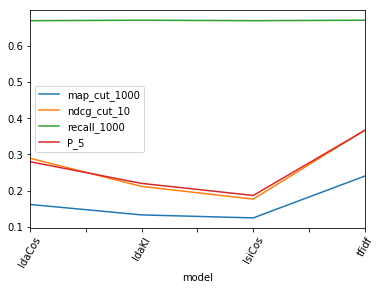

In [98]:
best_ndcg_plot_2 = best_ndcg_2.copy()
best_ndcg_plot_2.index = best_ndcg_plot_2.index.droplevel([1, 2])
#best_ndcg_plot = best_ndcg_plot.reset_index().drop(['parameter', 'parameter_value'], axis=1).set_index('model')
for col in performances_2:
    best_ndcg_plot_2[col].plot()
plt.xticks(rotation=60)
plt.legend()
plt.show()

In [99]:
query_performances_2 = queriesPerfomrmances(task_2, 'test')

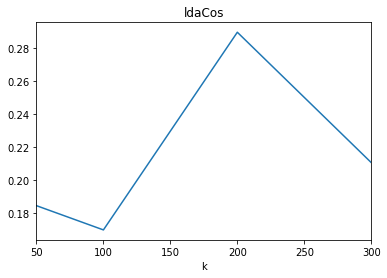

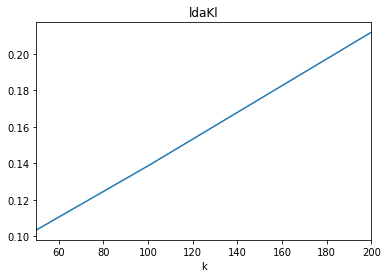

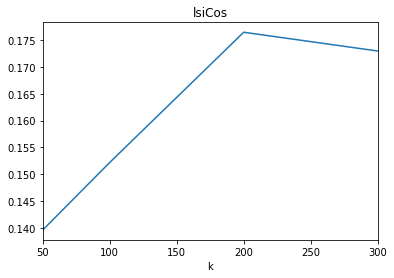

In [100]:
for ind, _ in performances_2.groupby(level=[0,1]):
    if ind[1] != '':
        plt.subplots(figsize=(6, 4))
        ax_2 =performances_2.loc[ind]['ndcg_cut_10'].plot()
        ax_2.set_xlabel(ind[1])
        ax_2.set_title(ind[0])

In [101]:
perform_test(task_2, query_performances_2, best_ndcg_2)

,ldaCos,ldaKl,lsiCos,tfidf
,k,k,k,
,200.0,200.0,200.0,-1.0
"('ldaCos', 'k', 200.0)",-,0,0.75,-0.75
"('ldaKl', 'k', 200.0)",0,-,0.5,-0.75
"('lsiCos', 'k', 200.0)",-0.75,-0.5,-,-0.75
"('tfidf', '', -1.0)",0.75,0.75,0.75,-


In [104]:
test_performances_2, _ = overallPerformances(task_2, 'test')
test_performances_2.loc[best_ndcg_2.index].style.background_gradient(cmap='viridis', low=.7, high=0, axis=0)

,,,map_cut_1000,ndcg_cut_10,recall_1000,P_5
model,parameter,parameter_value,,,,
ldaCos,k,200.0,0.1447,0.2391,0.6502,0.2533
ldaKl,k,200.0,0.1195,0.2061,0.651,0.2067
lsiCos,k,200.0,0.0831,0.1466,0.6502,0.1533
tfidf,,-1.0,0.2155,0.4169,0.651,0.4317


# Task 3

In [86]:
SIZE = 200
ITERS = 5

KNN_METHOD = 'KDTree'

parameters = [(0.2, i/10, j/10) for i in range(5) for j in range(5)]

### Multinoulli GLM

In [ ]:
backup_folder = './task3_multinoulli_backups'
if not os.path.exists(backup_folder):
    os.mkdir(backup_folder)


retrieval_start_time = time.time()

index = pyndri.Index('index/')

dictionary = pyndri.extract_dictionary(index)
sentences = pyndri.compat.IndriSentences(index, dictionary)

filename = 'data_structure.pickle'

(queries,
 tokenized_queries,
 avg_doc_length,
 total_terms,
 query_term_ids,
 document_lengths,
 unique_terms_per_document,
 term_occurr_in_query,
 inverted_index,
 collection_frequencies,
 background_probabilities) = pickle.load(open(filename, 'rb'))

num_queries = len(tokenized_queries.keys())

token2id, id2token, _ = index.get_dictionary()

start_time = time.time()

#Here we need to build a larger inverted index, containing an entry for each word in the documents, 
#not only the ones in the queries (as we need the occurrencies of the neighbors, which may not appear in the queries)
inverted_index = defaultdict(dict)
for int_doc_id in range(index.document_base(), index.maximum_document()):
    _, doc_token_ids = index.document(int_doc_id)

    words_count = defaultdict(int)

    for token_id in doc_token_ids:
        if token_id > 0:
            words_count[token_id] +=1

    for word, count in words_count.items():
        inverted_index[word][int_doc_id] = count

print('Inverted Index Built! {} seconds elapsed'.format(time.time() - start_time))

start_time = time.time()

#Build the Background Probabilities
if os.path.exists(os.path.join(backup_folder, 'background.pickle')):
    background = pickle.load(open(os.path.join(backup_folder, 'background.pickle'), 'rb'), encoding="bytes")
else:
    background = defaultdict(float)

    tot_words = 0.0
    
    #background probabilities here are different from Task1
    #in this case the "Words contributing equally" is used
    for int_doc_id in range(index.document_base(), index.maximum_document()):
        _, doc_token_ids = index.document(int_doc_id)
        for token_id in doc_token_ids:
            if token_id > 0:
                background[token_id] += 1
                tot_words += 1

    for k in background.keys():
        background[k] /= tot_words
        assert background[k] <= 1.0
        assert background[k] >= 0.0

    tot_docs = index.maximum_document() - index.document_base()

    background = dict(background)

    with open(os.path.join(backup_folder, 'background.pickle'), 'wb') as file:
        pickle.dump(background, file, protocol=4)

print('background loaded!')


if not os.path.exists(os.path.join(backup_folder, 'synonim_score.pickle')) or not os.path.exists(os.path.join(backup_folder, 'neighbour_score.pickle')) or not os.path.exists(os.path.join(backup_folder, 'words_normalization.pickle')):
    
    #Here we build our words embeddings
    
    if os.path.isdir('word2vec_trained'):
        model = Word2Vec.load('word2vec_trained/word2vec_trained_model')
        print('Model loaded!')
    else:
        model = gensim.models.Word2Vec(
            size=SIZE,  # Embedding size
            #window=10,  # One-sided window size
            window=5,  # One-sided window size
            #sg=True,  # Skip-gram.
            sg=False,  # Skip-gram.
            min_count=1,  # Minimum word frequency.
            sample=1e-3,  # Sub-sample threshold.
            #hs=True,
            hs=False,  # Hierarchical softmax.
            negative=10,  # Number of negative examples.
            iter=ITERS,  # Number of iterations.
            workers=7,  # Number of workers.
        )
        # Build vocab.
        model.build_vocab(sentences, trim_rule=None)
        model.train(sentences, total_examples=model.corpus_count, epochs=ITERS)

        print("Model Trained!")

        if not os.path.exists('word2vec_trained'):
            os.mkdir('word2vec_trained')

        model.save('word2vec_trained/word2vec_trained_model', ignore=[])

    word_vectors = model.wv
    del model
    gc.collect()
    
    # When using this pre-trained embeddings, some word are missing
    # word_vectors = KeyedVectors.load_word2vec_format('reduced_vectors_google.txt', binary=False)
    # SIZE = 300


    if word_vectors.syn0norm is None:
        word_vectors.init_sims(replace=True)
    
    #we put the embeddings in a dictionary using the token ids as key, easier to use later
    #N.B. the vectors are already normalized, making easier to compute the cosine similarity
    word_vectors = {id: word_vectors.word_vec(token, use_norm=True) for token, id in token2id.items() if token in word_vectors}

    print("Word Vectors dictionary built!")
    
    #recompute the document lengths removing the words without embeddings (in case 'reduced_vectors_google.txt' is used)
    document_lengths2 = defaultdict(lambda :0)
    for int_doc_id in range(index.document_base(), index.maximum_document()):
        ext_doc_id, doc_token_ids = index.document(int_doc_id)
        for word in doc_token_ids:
            if word > 0 and word in word_vectors:
                document_lengths2[int_doc_id] += 1.0

    print("Document Lengths rebuilt!")

else:
    document_lengths2 = document_lengths

#In this model a word has a probability of transforming in another one proportional to their similarity
#To compute this probability we divide their similarity by the sum of the similarity with all the words.
#The normalization factor can be precomputed for each word in order to save comptations

if os.path.exists(os.path.join(backup_folder, 'words_normalization.pickle')):
    words_normalization = pickle.load(open(os.path.join(backup_folder, 'words_normalization.pickle'), 'rb'),encoding="bytes")
else:
    words_sum = np.zeros(SIZE)
    
    #we can gather query word vector out of the summation: in this way the summation becomes 
    #a constant for all the words
    
    #first we sum all the words in the vocabulary
    for id, vector in word_vectors.items():
        words_sum += vector

    #now we compute the normalizaition for each word, using this precomputed vector
    
    #However, since cosine similarity ranges in [-1,1] we have to normalize it in [0, 1]
    # Our similarity is then sim(x, y) = 0.5*cossim(x, y) +0.5
    #actually, when using this similarity, gathering terms from the summation gives a slightly more
    #complex formula, but still efficient to compute
    words_normalization = {}
    for id, vector in word_vectors.items():
        words_normalization[id] = 0.5*np.dot(vector, words_sum) + 0.5*len(word_vectors)

    print("Words normalizations built!")

    with open(os.path.join(backup_folder, 'words_normalization.pickle'), 'wb') as file:
        pickle.dump(words_normalization, file, protocol=4)

print("Words normalizations loaded!")

if os.path.exists(os.path.join(backup_folder, 'neighbour_score.pickle')):
    neighbour_score = pickle.load(open(os.path.join(backup_folder, 'neighbour_score.pickle'), 'rb'), encoding="bytes")
else:

    start_time = time.time()

    dataset_i2id = {}
    dataset = []
    for i, w in enumerate(word_vectors.items()):
        dataset_i2id[i] = w[0]
        dataset.append(w[1].reshape(1, -1))

    dataset = np.array(dataset).reshape(-1, SIZE)

    queryset_i2id = []
    queryset = []
    for w in query_term_ids:
        if w in word_vectors:
            queryset_i2id.append(w)
            queryset.append(word_vectors[w].reshape(1, -1))

    queryset = np.array(queryset).reshape(-1, SIZE)


    if KNN_METHOD == 'flann':

        tree = FLANN()
        params = {  # autotuned on wiki corpus with target_precision=0.99
            'iterations': 50,
            #'multi_probe_level_': 2L,
            'cb_index': 0.20000000298023224,
            'centers_init': 'default',
            'log_level': 'info',
            'build_weight': 0.009999999776482582,
            'leaf_max_size': 20,
            'memory_weight': 0.0,
            'sample_fraction': 0.10000000149011612,
            'checks': 12288,
            'max_neighbors': -1,
            #'random_seed': 215924497,
            'trees': 1,
            'target_precision': 0.99999,
            #'table_number_': 12L,
            'sorted': 1,
            'branching': 32,
            'algorithm': 'kmeans',
            #'key_size_': 20L,
            'eps': 0.0,
            'cores': 0
        }
        #Flann is an approximated algorithm for KNN.
        #Queries are very fast, but it is not guaranteed to always return the optimal solution
        result, dists = tree.nn(dataset, queryset, 4, **params)
    else:
        #KDTree is an accurate algorithm for the K-NN problem. However, it is efficient only for low-dimensional
        #vector spaces, while for high-dimensional ones (as in our case) it doesn't perform much better than brute-force.
        #In the end we chose to employ this algorithm, though it takes much longer to give results
        tree = KDTree(dataset)
        dists, result = tree.query(queryset, k=4)

    neighbours = {}
    dists = []
    
    #parse the retrieved results
    for i, (ind, neigh) in enumerate(zip(queryset_i2id, result)):
        vec = queryset[i].flatten()
        #we retrieved one neighbor more because the word itself may be part of the words in the documents
        #and we want to exclude it from its own neighbors
        neighbours[ind] = [dataset_i2id[j] for j in neigh if dataset_i2id[j] != ind][:3]
        dists += [np.dot(dataset[j].flatten(), vec) for j in neigh if dataset_i2id[j] != ind]

    plt.hist(dists, bins=100)
    plt.savefig('neigh_dist.png')
    plt.close()

    del tree
    del dataset_i2id
    del dataset
    del queryset
    del queryset_i2id
    del result
    del dists

    gc.collect()

    print('Neighbours Computed; {} seconds elapsed'.format(time.time() - start_time))

    start_time = time.time()
    
    #Here we compute the neighbour scores for each of the words in the queries 
    #(i.e.. the value weighted by Beta)
    # this results are stored in the dictionary 'neighbour_score', which maps a word to its score
    
    neighbour_score = {}
    similarities = []
    for i, word in enumerate(query_term_ids):
        if word in word_vectors:
            vec = word_vectors[word]
            similarity = np.zeros(SIZE)
            neigh = np.zeros(SIZE)
            tot_background = 0
            
            #we can gather terms and compute a vector for the neighbourhood of a word and then multiply it by
            #the query word vector, saving a few computations
            for n in neighbours[word]:
                norm = word_vectors[n]
                similarity += norm
                neigh += norm * background[n]
                tot_background += background[n]

            #since cosine similarity ranges in [-1,1] we have to normalize it in [0, 1]
            # Our similarity is then sim(x, y) = 0.5*cossim(x, y) +0.5
            #actually, when using this similarity, gathering terms from the summation gives a slightly more
            #complex formula, but still efficient to compute
            similarity = 0.5*np.dot(similarity.flatten(), vec.flatten()) + 0.5*len(neighbours[word])
            neigh = 0.5*np.dot(neigh.flatten(), vec.flatten()) + 0.5*tot_background
            neighbour_score[word] = neigh / similarity

            similarities.append(similarity)

            assert neighbour_score[word] >= 0.0
            assert neighbour_score[word] <= 1.0

    plt.hist(similarities, bins = 100)
    plt.savefig('neighbours_similarities.png')
    plt.close()
    del similarities
    del neighbours
    gc.collect()

    print('Neighbourhood Scores and Background Computed; {} seconds elapsed'.format(time.time() - start_time))

    with open(os.path.join(backup_folder, 'neighbour_score.pickle'), 'wb') as file:
        pickle.dump(neighbour_score, file, protocol=4)

plt.hist(list(neighbour_score.values()), bins=10)
plt.savefig('neighbours.png')
plt.close()
print('neighbour_score loaded!')


#Now we build the TRANSFORMATION PROBABILITIES (the value multiplied by Alpha)
#results are stored in the 'synonim_score' dictionary.
#This dictionary maps a document to another dictionary, ampping each query word to its score

if os.path.exists(os.path.join(backup_folder, 'synonim_score.pickle')):
    synonim_score = pickle.load(open(os.path.join(backup_folder, 'synonim_score.pickle'), 'rb'), encoding="bytes")

else:

    tot_doc = index.maximum_document() - index.document_base()
    base = index.document_base()

    start_time = time.time()

    synonim_score = {}
    min_score = 0
    for int_doc_id in range(index.document_base(), index.maximum_document()):
        ext_doc_id, doc_token_ids = index.document(int_doc_id)

        if len(doc_token_ids) > 0:
            tf_w_vec = np.zeros(SIZE)

            document_tokens = set(doc_token_ids)

            tot_norm = 0.0
            
            #we can gather terms and precompute a vector for each document and then multiply it by
            #the query word vector, saving many computations
            for word in document_tokens:
                if word > 0 and word in word_vectors:
                    
                    tf_w_vec += word_vectors[word] * inverted_index[word][int_doc_id] / words_normalization[word]
                    
                    #this seems to lead to some small numerical instability
                    tot_norm += inverted_index[word][int_doc_id] / words_normalization[word]

            tf_w_vec /= document_lengths2[int_doc_id]
            tot_norm /= document_lengths2[int_doc_id]

            scores = defaultdict(float)
            for i, word in enumerate(query_term_ids):
                if word > 0 and word in word_vectors:

                    query_word_vec = word_vectors[word]
                    
                    #since cosine similarity ranges in [-1,1] we have to normalize it in [0, 1]
                    # Our similarity is then sim(x, y) = 0.5*cossim(x, y) +0.5
                    #actually, when using this similarity, gathering terms from the summation gives a slightly more
                    #complex formula, but still efficient to compute
                    
                    scores[word] = 0.5*np.dot(query_word_vec, tf_w_vec) + 0.5*tot_norm
                    min_score = min(scores[word], min_score)
                    
                    #probably due to some numerical instability (as written above)
                    #some scores happen to be slightly lower than 0
                    #Therefore, we clip values to 0 if negative
                    assert scores[word] >= -0.03 and scores[word] <= 1, "{}, {}, {}".format(int_doc_id, word, scores[word])
                    scores[word] = max(scores[word], 0.0)


            synonim_score[int_doc_id] = scores
        else:
            synonim_score[int_doc_id] = defaultdict(float)

    print('Min score found: ' + str(min_score))

    gc.collect()

    print('DOCUMENTS VECTORS and SCORES COMPUTED; {} seconds elapsed'.format(time.time() - start_time))

    ### Don't pickle this dictionary unless you have a lot or RAM (16 GB is not enough)

    #with open(os.path.join(backup_folder, 'synonim_score.pickle'), 'wb') as file:
    #    pickle.dump(synonim_score, file, protocol=4)
    #print('Synonim Score backup stored on file')

print('synonim_score loaded! Ready To Rank!')

scores = []
for d in synonim_score.values():
    scores += list(d.values())
plt.hist(scores, bins = 100, log=True)
plt.savefig('synonim.png')
plt.close()
del scores
gc.collect()

start = time.time()

#ranks all the documents w.r.t. a query
def rank_query(query,
               lamb,
               alpha,
               beta,
               index=index,
               synonim_score=synonim_score,
               neighbour_score=neighbour_score,
               background=background
               ):

    query_id, query_terms = query
    scores = []
    
    #we rank each document
    for int_doc_id in range(index.document_base(), index.maximum_document()):
        ext_doc_id, _ = index.document(int_doc_id)

        score = 0
        empty = True
        # for each word in the query
        for query_term_id in query_terms:
            if query_term_id > 0 and query_term_id in word_vectors:
                empty = False
                prob = 0
                #we combine the 4 probabilities using alpha, beta and lambda
                if int_doc_id in inverted_index[query_term_id]:
                    prob += lamb * inverted_index[query_term_id][int_doc_id] / document_lengths2[int_doc_id]

                prob += alpha * synonim_score[int_doc_id][query_term_id]
                prob += beta * neighbour_score[query_term_id]

                prob += (1.0 - lamb - alpha - beta) * background[query_term_id]
                
                #we use log probabilities, so we sum the logarithm of each probability
                score += np.log(prob)
        if empty:
            score = float('-inf')

        scores.append((score, ext_doc_id))
    
    #keep only the 1000 best documents to save memory
    ranking = sorted(scores, key = lambda x : -x[0])[:1000]
    del scores
    gc.collect()

    return query_id, ranking

#Once done all the shared computations and built all the probabilities,
#we combine them using different values of alpha, beta and lambda
for lamb, alpha, beta in parameters:
    model_name = 'multinoulliglm_[{}_{}_{}]'.format(lamb, alpha, beta)
    outdir = './rankings'

    if not os.path.exists(outdir):
        os.mkdir(outdir)

    run_out_path = os.path.join(outdir, '{}.run'.format(model_name))

    if not os.path.exists(run_out_path):

        start_time = time.time()

        print('{}, {}, {}: Starting to rank'.format(lamb, alpha, beta))

        data = []
        for i, query in enumerate(tokenized_queries.items()):
            data.append(rank_query(query, lamb, alpha, beta))
            if i % 10 == 0:
                print('\t', i, 'out of', len(tokenized_queries))
        data = dict(data)

        print('{}, {}, {}: SCORES BUILT. {} seconds elapsed'.format(lamb, alpha, beta, time.time() - start_time))


        print('Printing results')

        with open(run_out_path, 'w') as f_out:
            write_run(
                model_name=model_name,
                data=data,
                out_f=f_out,
                max_objects_per_query=1000)

        del data
        gc.collect()

        print('{}, {}, {}: finished!! {} seconds elapsed'.format(lamb, alpha, beta, time.time() - start_time))


    

### Bernoulli GLM

In [ ]:
backup_folder = './task3_bernoulli_backups'
if not os.path.exists(backup_folder):
    os.mkdir(backup_folder)

retrieval_start_time = time.time()

index = pyndri.Index('index/')

dictionary = pyndri.extract_dictionary(index)
sentences = pyndri.compat.IndriSentences(index, dictionary)

filename = 'data_structure.pickle'

(queries,
 tokenized_queries,
 avg_doc_length,
 total_terms,
 query_term_ids,
 document_lengths,
 unique_terms_per_document,
 term_occurr_in_query,
 inverted_index,
 collection_frequencies,
 background_probabilities) = pickle.load(open(filename, 'rb'))

num_queries = len(tokenized_queries.keys())

token2id, id2token, _ = index.get_dictionary()

start_time = time.time()

inverted_index = defaultdict(dict)
for int_doc_id in range(index.document_base(), index.maximum_document()):
    _, doc_token_ids = index.document(int_doc_id)

    words_count = defaultdict(int)

    for token_id in doc_token_ids:
        if token_id > 0:
            words_count[token_id] +=1

    for word, count in words_count.items():
        inverted_index[word][int_doc_id] = count

print('Inverted Index Built! {} seconds elapsed'.format(time.time() - start_time))

start_time = time.time()

#Building Background Probabilities
if os.path.exists(os.path.join(backup_folder, 'background.pickle')):
    background = pickle.load(open(os.path.join(backup_folder, 'background.pickle'), 'rb'), encoding="bytes")
else:
    background = defaultdict(float)

    tot_words = 0.0

    for int_doc_id in range(index.document_base(), index.maximum_document()):
        _, doc_token_ids = index.document(int_doc_id)
        for token_id in doc_token_ids:
            if token_id > 0:
                background[token_id] += 1
                tot_words += 1

    for k in background.keys():
        background[k] /= tot_words
        assert background[k] <= 1.0
        assert background[k] >= 0.0

    tot_docs = index.maximum_document() - index.document_base()

    background = dict(background)

    with open(os.path.join(backup_folder, 'background.pickle'), 'wb') as file:
        pickle.dump(background, file, protocol=4)

print('background loaded!')



if not os.path.exists(os.path.join(backup_folder, 'synonim_score.pickle')) or not os.path.exists(os.path.join(backup_folder, 'neighbour_score.pickle')):
    
    #Building the embeddings
    
    if os.path.isdir('word2vec_trained'):
        model = Word2Vec.load('word2vec_trained/word2vec_trained_model')
        print('Model loaded!')
    else:
        model = gensim.models.Word2Vec(
            size=SIZE,  # Embedding size
            #window=10,  # One-sided window size
            window=5,  # One-sided window size
            #sg=True,  # Skip-gram.
            sg=False,  # Skip-gram.
            min_count=1,  # Minimum word frequency.
            sample=1e-3,  # Sub-sample threshold.
            #hs=True,
            hs=False,  # Hierarchical softmax.
            negative=10,  # Number of negative examples.
            iter=ITERS,  # Number of iterations.
            workers=7,  # Number of workers.
        )
        # Build vocab.
        model.build_vocab(sentences, trim_rule=None)
        model.train(sentences, total_examples=model.corpus_count, epochs=ITERS)

        print("Model Trained!")

        if not os.path.exists('word2vec_trained'):
            os.mkdir('word2vec_trained')

        model.save('word2vec_trained/word2vec_trained_model', ignore=[])

    word_vectors = model.wv
    del model
    gc.collect()

    # word_vectors = KeyedVectors.load_word2vec_format('reduced_vectors_google.txt', binary=False)
    # SIZE = 300


    if word_vectors.syn0norm is None:
        word_vectors.init_sims(replace=True)

    #retrieve normalized embeddings
    word_vectors = {id: word_vectors.word_vec(token, use_norm=True) for token, id in token2id.items() if token in word_vectors}

    print("Word Vectors dictionary built!")

    document_lengths2 = defaultdict(lambda :0)
    for int_doc_id in range(index.document_base(), index.maximum_document()):
        ext_doc_id, doc_token_ids = index.document(int_doc_id)
        for word in doc_token_ids:
            if word > 0 and word in word_vectors:
                document_lengths2[int_doc_id] += 1.0

    print("Document Lengths rebuilt!")
else:
    document_lengths2 = document_lengths

#Build Neighbour Scores (terms weighted by Beta)
# dictionary 'neighbour_score' maps query word to its neighbour score
if os.path.exists(os.path.join(backup_folder, 'neighbour_score.pickle')):
    neighbour_score = pickle.load(open(os.path.join(backup_folder, 'neighbour_score.pickle'), 'rb'), encoding="bytes")
else:
    start_time = time.time()

    dataset_i2id = {}
    dataset = []
    for i, w in enumerate(word_vectors.items()):
        dataset_i2id[i] = w[0]
        dataset.append(w[1].reshape(1, -1))

    dataset = np.array(dataset).reshape(-1, SIZE)

    queryset_i2id = []
    queryset = []
    for w in query_term_ids:
        if w in word_vectors:
            queryset_i2id.append(w)
            queryset.append(word_vectors[w].reshape(1, -1))

    queryset = np.array(queryset).reshape(-1, SIZE)
    
    #Using a KNN algorithm we retrieve the nearest enighbors of each word
    if KNN_METHOD == 'flann':
        tree = FLANN()
        params = {  # autotuned on wiki corpus with target_precision=0.99
            'iterations': 20,
            #'multi_probe_level_': 2L,
            'cb_index': 0.20000000298023224,
            'centers_init': 'default',
            'log_level': 'info',
            'build_weight': 0.009999999776482582,
            'leaf_max_size': 20,
            'memory_weight': 0.0,
            'sample_fraction': 0.10000000149011612,
            'checks': 12288,
            'max_neighbors': -1,
            #'random_seed': 215924497,
            'trees': 1,
            'target_precision': 0.99999,
            #'table_number_': 12L,
            'sorted': 1,
            'branching': 32,
            'algorithm': 'kmeans',
            #'key_size_': 20L,
            'eps': 0.0,
            'cores': 0
        }

        result, dists = tree.nn(dataset, queryset, 4, **params)
    else:
        tree = KDTree(dataset)
        dists, result = tree.query(queryset, k=4)
    
    #Builing the neighbours sets
    neighbours = {}
    dists = []
    for i, (ind, neigh) in enumerate(zip(queryset_i2id, result)):
        vec = queryset[i].flatten()
        neighbours[ind] = [dataset_i2id[j] for j in neigh if dataset_i2id[j] != ind][:3]
        dists += [np.dot(dataset[j].flatten(), vec) for j in neigh if dataset_i2id[j] != ind]


    plt.hist(dists, bins=100)
    plt.savefig('neigh_dist.png')
    plt.close()

    del tree
    del dataset_i2id
    del dataset
    del queryset
    del queryset_i2id
    del result
    del dists

    gc.collect()

    print('Neighbours Computed; {} seconds elapsed'.format(time.time() - start_time))

    start_time = time.time()
    
    #Computing the Neighbour Scores
    neighbour_score = {}
    #similarities = []
    for i, word in enumerate(query_term_ids):
        if word in word_vectors:
            vec = word_vectors[word]
            similarity = np.zeros(SIZE)
            neigh = np.zeros(SIZE)
            tot_background = 0
            for n in neighbours[word]:
                norm = word_vectors[n]
                similarity += norm
                neigh += norm * background[n]
                tot_background += background[n]
            
            
            similarity = 0.5*np.dot(similarity.flatten(), vec.flatten()) + 0.5*len(neighbours[word])
            neigh = 0.5*np.dot(neigh.flatten(), vec.flatten()) + 0.5*tot_background
            neighbour_score[word] = neigh / similarity
            #similarities.append(similarity)
            assert neighbour_score[word] >= 0.0
            assert neighbour_score[word] <= 1.0

    # plt.hist(similarities, bins = 100)
    # plt.savefig('similarities_bern.png')
    # plt.close()
    # del similarities
    del neighbours
    gc.collect()

    print('Neighbourhood Scores and Background Computed; {} seconds elapsed'.format(time.time() - start_time))

    with open(os.path.join(backup_folder, 'neighbour_score.pickle'), 'wb') as file:
        pickle.dump(neighbour_score, file, protocol=4)

print('neighbour_score loaded!')

#Here we build the TRANSFORMATION PROBABILITIES (the term weighted by Alpha) 
#the results are stored in the 'synonim_score' dictionaty, which maps a document to another dictionary,
#mapping each word to its score in that document
if os.path.exists(os.path.join(backup_folder, 'synonim_score.pickle')):
    synonim_score = pickle.load(open(os.path.join(backup_folder, 'synonim_score.pickle'), 'rb'), encoding="bytes")

else:

    tot_doc = index.maximum_document() - index.document_base()
    base = index.document_base()

    start_time = time.time()

    #build the "sub-dictionary" of a document (i.e. the "value" to which this document is associated in the 'synonim_score' dictionary)
    # contains the scores of each word
    def document_vector(int_doc_id,
                        index=index,
                        word_vectors=word_vectors,
                        query_term_ids=query_term_ids
                        ):

        ext_doc_id, doc_token_ids = index.document(int_doc_id)

        if len(doc_token_ids) > 0:
            vec = np.zeros(SIZE)
            tf_w_vec = np.zeros(SIZE)

            document_tokens = set(doc_token_ids)
            
            #gathering terms enables us to precompute a vector for the document, useful later to save computations
            for word in document_tokens:
                if word > 0 and word in word_vectors:
                    norm = word_vectors[word]

                    vec += norm

                    tf_w_vec += norm * inverted_index[word][int_doc_id]

            tf_w_vec /= document_lengths2[int_doc_id]

            scores = defaultdict(float)
            for i, word in enumerate(query_term_ids):
                if word > 0 and word in word_vectors:

                    query_word_vec = word_vectors[word]
                    
                    #We normalize the cosine similarity in the range [0, 1]
                    
                    scores[word] = 0.5*np.dot(query_word_vec, tf_w_vec) + 0.5
                    
                    # ORIGINAL GLM
                    ### Decomment this line to use the original version (from the paper) of the algorithm
                    #scores[word] /= 0.5*np.dot(query_word_vec, vec) + 0.5*document_lengths2[int_doc_id]

                    assert scores[word] >= 0 and scores[word] <= 1, "{}, {}, {}".format(int_doc_id, word, scores[word])

            return int_doc_id, scores
        else:
            return int_doc_id, defaultdict(float)

    synonim_score = dict([document_vector(d) for d in range(index.document_base(), index.maximum_document())])

    gc.collect()

    print('DOCUMENTS VECTORS and SCORES COMPUTED; {} seconds elapsed'.format(time.time() - start_time))

    ### Don't pickle this dictionary unless you have a lot of RAM (> 16 GB)...
    #with open(os.path.join(backup_folder, 'synonim_score.pickle'), 'wb') as file:
    #    pickle.dump(synonim_score, file, protocol=4)
    #print('Synonim Score backup stored on file')

print('synonim_score loaded! Ready To Rank!')

scores = []
for d in synonim_score.values():
    scores += list(d.values())
plt.hist(scores, bins = 100, log=True)
plt.savefig('synonim_bern.png')
plt.close()
del scores
gc.collect()

start = time.time()

#rank all the documents with respect to a query

def rank_query(query,
               lamb,
               alpha,
               beta,
               index=index,
               synonim_score=synonim_score,
               neighbour_score=neighbour_score,
               background=background
               ):

    query_id, query_terms = query
    scores = []

    for int_doc_id in range(index.document_base(), index.maximum_document()):
        ext_doc_id, _ = index.document(int_doc_id)

        score = 0
        empty = True
        #for each word we compute its probability combining the precomputed probabilities
        for query_term_id in query_terms:
            if query_term_id > 0 and query_term_id in word_vectors:
                empty = False
                prob = 0
                if int_doc_id in inverted_index[query_term_id]:
                    prob += lamb * inverted_index[query_term_id][int_doc_id] / document_lengths2[int_doc_id]

                prob += alpha * synonim_score[int_doc_id][query_term_id]
                prob += beta * neighbour_score[query_term_id]

                prob += (1.0 - lamb - alpha - beta) * background[query_term_id]
                
                #since we employ log-probabilities, we sum te log of words' probabilities
                score += np.log(prob)
        if empty:
            score = float('-inf')

        scores.append((score, ext_doc_id))
    
    #to save memory
    ranking = sorted(scores, key=lambda x: -x[0])[:1000]
    del scores
    gc.collect()

    return query_id, ranking


#for each combination of parameter to test, we employ the precomputed probabilities and build a new ranking
for lamb, alpha, beta in parameters:
    model_name = 'bernoulliglm_[{}_{}_{}]'.format(lamb, alpha, beta)
    outdir = './rankings'

    if not os.path.exists(outdir):
        os.mkdir(outdir)

    run_out_path = os.path.join(outdir, '{}.run'.format(model_name))

    if not os.path.exists(run_out_path):
        start_time = time.time()
        print('{}, {}, {}: Starting to rank'.format(lamb, alpha, beta))

        data = []
        for i, query in enumerate(tokenized_queries.items()):
            data.append(rank_query(query, lamb, alpha, beta))
            if i % 10 == 0:
                print('\t', i, 'out of', len(tokenized_queries))
        data = dict(data)

        print('{}, {}, {}: SCORES BUILT. {} seconds elapsed'.format(lamb, alpha, beta, time.time() - start_time))

        print('Printing results')

        with open(run_out_path, 'w') as f_out:
            write_run(
                model_name=model_name,
                data=data,
                out_f=f_out,
                max_objects_per_query=1000)

        del data
        gc.collect()

        print('{}, {}, {}: finished!!. {} seconds elapsed'.format(lamb, alpha, beta, time.time() - start_time))




### Generalized TF-IDF

In [ ]:
NEIGHBOURS = 4
THRESHOLD = 0.6


backup_folder = './task3_backups_max'
if not os.path.exists(backup_folder):
    os.mkdir(backup_folder)

retrieval_start_time = time.time()

index = pyndri.Index('index/')


dictionary = pyndri.extract_dictionary(index)
sentences = pyndri.compat.IndriSentences(index, dictionary)

filename = 'data_structure.pickle'

(queries,
 tokenized_queries,
 avg_doc_length,
 total_terms,
 query_term_ids,
 document_lengths,
 unique_terms_per_document,
 term_occurr_in_query,
 inverted_index,
 collection_frequencies,
 background_probabilities) = pickle.load(open(filename, 'rb'))

num_queries = len(tokenized_queries.keys())

token2id, id2token, _ = index.get_dictionary()

start_time = time.time()

inverted_index = defaultdict(dict)
for int_doc_id in range(index.document_base(), index.maximum_document()):
    _, doc_token_ids = index.document(int_doc_id)

    words_count = defaultdict(int)

    for token_id in doc_token_ids:
        if token_id > 0:
            words_count[token_id] += 1

    for word, count in words_count.items():
        inverted_index[word][int_doc_id] = count

print('Inverted Index Built! {} seconds elapsed'.format(time.time() - start_time))


start_time = time.time()

#Build the words embeddings

if os.path.isdir('word2vec_trained'):
    model = Word2Vec.load('word2vec_trained/word2vec_trained_model')
    print('Model loaded!')
else:
    model = gensim.models.Word2Vec(
        size=SIZE,  # Embedding size
        # window=10,  # One-sided window size
        window=5,  # One-sided window size
        # sg=True,  # Skip-gram.
        sg=False,  # Skip-gram.
        min_count=1,  # Minimum word frequency.
        sample=1e-3,  # Sub-sample threshold.
        # hs=True,
        hs=False,  # Hierarchical softmax.
        negative=10,  # Number of negative examples.
        iter=ITERS,  # Number of iterations.
        workers=7,  # Number of workers.
    )
    # Build vocab.
    model.build_vocab(sentences, trim_rule=None)
    model.train(sentences, total_examples=model.corpus_count, epochs=ITERS)

    print("Model Trained!")

    if not os.path.exists('word2vec_trained'):
        os.mkdir('word2vec_trained')

    model.save('word2vec_trained/word2vec_trained_model', ignore=[])

word_vectors = model.wv
del model
gc.collect()

# word_vectors = KeyedVectors.load_word2vec_format('reduced_vectors_google.txt', binary=False)
# SIZE = 300

if word_vectors.syn0norm is None:
    word_vectors.init_sims(replace=True)

#build the dictionary of normalized word embeddings
word_vectors = {id : word_vectors.word_vec(token, use_norm=True) for token, id in token2id.items() if token in word_vectors}

SIZE = len(word_vectors[list(word_vectors.keys())[0]])

print("Word Vectors dictionary built!")

dataset_i2id = {}
dataset = []
for i, w in enumerate(word_vectors.items()):
    dataset_i2id[i] = w[0]
    dataset.append(w[1].reshape(1, -1))

dataset = np.array(dataset).reshape(-1, SIZE)

queryset_i2id = []
queryset = []
i = 0
for w in query_term_ids:
    if w in word_vectors:
        queryset_i2id.append(w)
        queryset.append(word_vectors[w].reshape(1, -1))
        i += 1

queryset = np.array(queryset).reshape(-1, SIZE)

#Retrieve the neighbors of each word

if KNN_METHOD == 'flann':

    tree = FLANN()
    params = {  # autotuned on wiki corpus with target_precision=0.99
        'iterations': 60,
        # 'multi_probe_level_': 2L,
        'cb_index': 0.20000000298023224,
        'centers_init': 'default',
        'log_level': 'info',
        'build_weight': 0.009999999776482582,
        'leaf_max_size': 20,
        'memory_weight': 0.0,
        'sample_fraction': 0.10000000149011612,
        'checks': 12288,
        'max_neighbors': -1,
        # 'random_seed': 215924497,
        'trees': 1,
        'target_precision': 0.99999,
        # 'table_number_': 12L,
        'sorted': 1,
        'branching': 32,
        'algorithm': 'kmeans',
        # 'key_size_': 20L,
        'eps': 0.0,
        'cores': 0
    }
    result, dists = tree.nn(dataset, queryset, NEIGHBOURS +1,
                            **params)
else:
    tree = KDTree(dataset)
    dists, result = tree.query(queryset, k=NEIGHBOURS +1)

neighbours = defaultdict(list)
#parse the retrieved neighbors
for ind, neigh in zip(queryset_i2id, result):
    vec = queryset[ind].flatten()
    neighbours[ind] = [dataset_i2id[j] for j in neigh if dataset_i2id[j] != ind and np.dot(vec, dataset[j].flatten()) > THRESHOLD][:NEIGHBOURS]

del tree
del result
del dists
del dataset_i2id
del dataset
del queryset
del queryset_i2id
gc.collect()

print('Neighbours Computed; {} seconds elapsed'.format(time.time() - start_time))

start_time = time.time()

#Now, we compute the generalized Document Frequencies

documents_frequency = {}

for i, word in enumerate(query_term_ids):

    docs = defaultdict(lambda: 0.0)
    
    #A word fully belongs to a documents if it appears in it
    for d in inverted_index[word].keys():
        docs[d] = 1.0

    if word in word_vectors:
        vec = word_vectors[word]
        #A word can belong to a documents with a degree equal to the maximum similarity of 
        #the neighbors which appear in the document
        for neigh in neighbours[word]:
            similarity = 0.5 * np.dot(vec, word_vectors[neigh]) + 0.5
            for d in inverted_index[neigh].keys():
                docs[d] = max(docs[d], similarity)

    documents_frequency[word] = sum(docs.values())
    del docs

print('Documents Frequencies COmputed; {} seconds elapsed'.format(time.time() - start_time))

start_time = time.time()

#Here we compute the Generalized Term Frequencies

term_frequencies = defaultdict(lambda: defaultdict(float))

for i, word in enumerate(query_term_ids):
    
    #the frequency of a word in a document is:
    
    
    #the number of its occurencies
    for d in inverted_index[word].keys():
        term_frequencies[word][d] = inverted_index[word][d]
    
    #plus the number of occurrencies of its neighbors, weighted by their similarities
    if word in word_vectors:
        vec = word_vectors[word]
        for neigh in neighbours[word]:
            #we employ a normalized verion of the cosin similarity
            similarity = 0.5 * np.dot(vec, word_vectors[neigh]) + 0.5

            for d, f in inverted_index[neigh].items():
                term_frequencies[word][d] += similarity * f


print('Term Frequencies COmputed; {} seconds elapsed'.format(time.time() - start_time))

num_documents = index.maximum_document() - index.document_base()

start = time.time()


def tfidf(int_document_id, query_term_id):

    if int_document_id in term_frequencies[word]:
        df = documents_frequency[query_term_id]
        idf = math.log(num_documents) - math.log(df) if df else 0
        tfidf = np.log(1 + term_frequencies[query_term_id][int_document_id]) * idf

        return tfidf
    else:
        return 0

#ranks all the documents w.r.t to a query
def rank_query(query):

    query_id, query_terms = query
    scores = []

    for int_doc_id in range(index.document_base(), index.maximum_document()):
        ext_doc_id, _ = index.document(int_doc_id)

        score = 0
        for query_term_id in query_terms:
            if query_term_id > 0:
                score += tfidf(int_doc_id, query_term_id)

        scores.append((score, ext_doc_id))
    
    #save some memory
    ranking = sorted(scores, key=lambda x: -x[0])[:1000]
    del scores
    gc.collect()

    return query_id, ranking

model_name = 'gentfidf_t_' + str(THRESHOLD)
outdir = './rankings'

if not os.path.exists(outdir):
    os.mkdir(outdir)

run_out_path = os.path.join(outdir, '{}.run'.format(model_name))

if not os.path.exists(run_out_path):
    start_time = time.time()

    data = []
    for i, query in enumerate(tokenized_queries.items()):
        data.append(rank_query(query))
        if i % 10 == 0:
            print('\t', i, 'out of', len(tokenized_queries))
    data = dict(data)

    print('SCORES BUILT. {} seconds elapsed'.format(time.time() - start_time))


    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)

    del data
    gc.collect()

    print('Everything FINISHED!! {} seconds elapsed'.format(time.time() - start_time))


### Mean GLM

In [ ]:
#base-line model, document and query are represented as average of normalized word embeddings
# a pair doc-query is scored based on cosine similarity between representations

#Build the embeddings
if os.path.isdir('word2vec_trained'):
    model = Word2Vec.load('word2vec_trained/word2vec_trained_model')
    print('Model loaded!')
else:
    model = gensim.models.Word2Vec(
        size=SIZE,  # Embedding size
        #window=10,  # One-sided window size
        window=5,  # One-sided window size
        #sg=True,  # Skip-gram.
        sg=False,  # Skip-gram.
        min_count=1,  # Minimum word frequency.
        sample=1e-3,  # Sub-sample threshold.
        #hs=True,
        hs=False,  # Hierarchical softmax.
        negative=10,  # Number of negative examples.
        iter=ITERS,  # Number of iterations.
        workers=7,  # Number of workers.
    )
    # Build vocab.
    model.build_vocab(sentences, trim_rule=None)
    model.train(sentences, total_examples=model.corpus_count, epochs=ITERS)

    print("Model Trained!")

    if not os.path.exists('word2vec_trained'):
        os.mkdir('word2vec_trained')

    model.save('word2vec_trained/word2vec_trained_model', ignore=[])

word_vectors = model.wv
del model
gc.collect()

if word_vectors.syn0norm is None:
    word_vectors.init_sims(replace=True)

#retrieve the normalized embeddings
word_vectors = {id : word_vectors.word_vec(token, use_norm=True) for token, id in token2id.items()}


start = time.time()
#compute the representation of a document, i.e. the mean of the embeddings of its words (normalized)
def representation(document):
    vector = np.zeros(SIZE)
    if len(document) == 0:
        return np.zeros(SIZE)
    else:
        for term_id in document:
            if term_id != 0:
                vector += word_vectors[term_id]

        return vector/len(document)

representations = {}

for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)
    doc_rep = representation(doc_token_ids)
    representations[int_doc_id] = doc_rep


print('starting to rank')

#ranks the documents w.r.t. a query
def rank_query(query):

    query_id, query_terms = query
    scores = []

    query_rep = representation(query_terms)

    for int_doc_id in range(index.document_base(), index.maximum_document()):
        ext_doc_id, doc_token_ids = index.document(int_doc_id)

        doc_rep = representations[int_doc_id]

        if len(doc_token_ids) == 0:
            score = -2

        else:
            score = np.dot(query_rep, doc_rep)

        scores.append((score, ext_doc_id))

    ranking = sorted(scores, key = lambda x : -x[0])[:1000]
    del scores
    gc.collect()

    return query_id, ranking



model_name = 'meanglm'
outdir = './rankings' 

if not os.path.exists(outdir):
    os.mkdir(outdir)

run_out_path = os.path.join(outdir, '{}.run'.format(model_name))

if not os.path.exists(run_out_path):

    data = []
    for i, query in enumerate(tokenized_queries.items()):
        data.append(rank_query(query))
        if i % 10 == 0:
            print('\t', i, 'out of', len(tokenized_queries))
    data = dict(data)


    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)

    del data
    gc.collect()

## Analysis

In [31]:
task_3 = ['tfidf', 'jm'] + ['multinoulliglm', 'bernoulliglm', 'gentfidf', 'meanglm']

In [16]:
par_re = re.compile('(?:([^_]+)(?:_\[([0-9]+(?:\.[0-9]+)?)(?:_([0-9]+(?:\.[0-9]+)?))?(?:_([0-9]+(?:\.[0-9]+)?))?\])?)')

def overallPerformancesMultiParams(models, directory, params_names):
    
    assert len(params_names) == 3
    
    index = ['model'] + params_names
    
    performances = collections.defaultdict(dict)

    for filename in glob.glob(os.path.join("./", directory, "*.all")):
        model = os.path.splitext(os.path.basename(filename))[0]
        
        model = par_re.match(model).groups('')
                
        model_name = model[0]
        params = model[1:]
        
        
        if model_name in models:
            #print(model)
            with open(filename, 'r') as f:
                for line in f:
                    line = line.split()

                    measure = line[0]
                    val = float(line[2])
                    performances[model][measure] = val


    performances = pd.DataFrame.from_dict(performances, orient='index')
    performances.index.rename(index, inplace=True)
    
    return performances

def validate(performances, measure):
    return performances.iloc[performances.reset_index().groupby(['model'])[measure].idxmax()].copy()

In [32]:
performances3 = overallPerformancesMultiParams(task_3, 'evaluations', ['lambda', 'alpha', 'beta'])

Choosing the best set of parameters using the ndcg@10 on the Validation Set leads to the standard JM model, i.e $\alpha = 0$ and $\beta = 0$ (though the smoothing applied to the Generalized Language Models is different from the one used in task 1. Therefore, the values are slightly different form our 'jm' model)
We chose to fix $\lambda$ to $0.2$ as it was suggested in the original paper and since this value was the best parameter found in Task 1 for the JM model.

In [33]:
best_ndcg3 = validate(performances3, 'ndcg_cut_10')
best_ndcg3

,,,,recall_1000,ndcg_cut_10,P_5,map_cut_1000
model,lambda,alpha,beta,,,,
bernoulliglm,0.2,0.0,0.0,0.6298,0.4002,0.3933,0.2272
gentfidf,,,,0.0040,0.0173,0.0133,0.0014
jm,,,,0.6141,0.3744,0.3800,0.2231
meanglm,,,,0.4283,0.0789,0.0733,0.0512
multinoulliglm,0.2,0.0,0.0,0.6298,0.4002,0.3933,0.2272
tfidf,,,,0.6712,0.3672,0.3667,0.2403


In [34]:
validate(performances3, 'P_5')

,,,,recall_1000,ndcg_cut_10,P_5,map_cut_1000
model,lambda,alpha,beta,,,,
bernoulliglm,0.2,0.0,0.0,0.6298,0.4002,0.3933,0.2272
gentfidf,,,,0.0040,0.0173,0.0133,0.0014
jm,,,,0.6141,0.3744,0.3800,0.2231
meanglm,,,,0.4283,0.0789,0.0733,0.0512
multinoulliglm,0.2,0.0,0.0,0.6298,0.4002,0.3933,0.2272
tfidf,,,,0.6712,0.3672,0.3667,0.2403


When considering map@1000 or recall@1000, the smoothing from neighbour words seems to be slightly useful

In [35]:
validate(performances3, 'map_cut_1000')

,,,,recall_1000,ndcg_cut_10,P_5,map_cut_1000
model,lambda,alpha,beta,,,,
bernoulliglm,0.2,0.0,0.4,0.6429,0.3818,0.3867,0.2370
gentfidf,,,,0.0040,0.0173,0.0133,0.0014
jm,,,,0.6141,0.3744,0.3800,0.2231
meanglm,,,,0.4283,0.0789,0.0733,0.0512
multinoulliglm,0.2,0.0,0.4,0.6429,0.3818,0.3867,0.2369
tfidf,,,,0.6712,0.3672,0.3667,0.2403


In [36]:
validate(performances3, 'recall_1000')

,,,,recall_1000,ndcg_cut_10,P_5,map_cut_1000
model,lambda,alpha,beta,,,,
bernoulliglm,0.2,0.0,0.4,0.6429,0.3818,0.3867,0.2370
gentfidf,,,,0.0040,0.0173,0.0133,0.0014
jm,,,,0.6141,0.3744,0.3800,0.2231
meanglm,,,,0.4283,0.0789,0.0733,0.0512
multinoulliglm,0.2,0.0,0.4,0.6429,0.3818,0.3867,0.2369
tfidf,,,,0.6712,0.3672,0.3667,0.2403


In [37]:
validate(performances3.query("alpha not in ['0.0']"), 'ndcg_cut_10')

,,,,recall_1000,ndcg_cut_10,P_5,map_cut_1000
model,lambda,alpha,beta,,,,
bernoulliglm,0.2,0.1,0.0,0.5694,0.2443,0.2267,0.1428
gentfidf,,,,0.0040,0.0173,0.0133,0.0014
jm,,,,0.6141,0.3744,0.3800,0.2231
meanglm,,,,0.4283,0.0789,0.0733,0.0512
multinoulliglm,0.2,0.1,0.4,0.4364,0.2111,0.2133,0.1355
tfidf,,,,0.6712,0.3672,0.3667,0.2403


In [38]:
def queriesPerfomrmancesMultiParams(models, directory, params_names):
    
    assert len(params_names) == 3
    
    query_performances = collections.defaultdict(dict)

    for filename in glob.glob(os.path.join("./", directory, "*.eval")):

        tmp = os.path.basename(filename).split('.')

        model = par_re.match('.'.join(tmp[:-2])).groups('')
        model_name = model[0]
        measure = tmp[-2]
        
        if model_name in models:
            
            with open(filename, 'r') as f:
                for line in f:
                    line = line.split()

                    query_id = line[1]
                    val = float(line[2])
                    
                    if query_id != 'all':
                        key = tuple(list(model) + [int(query_id)])
                        query_performances[key][measure] = val

    query_performances = pd.DataFrame.from_dict(query_performances, orient='index')
    query_performances.index.rename(['model_name'] + params_names + ['query_id'], inplace=True)
    query_performances.sort_index(inplace=True)
    
    return query_performances

In [39]:
query_performances3 = queriesPerfomrmancesMultiParams(task_3, 'test', ['lambda', 'alpha', 'beta'])

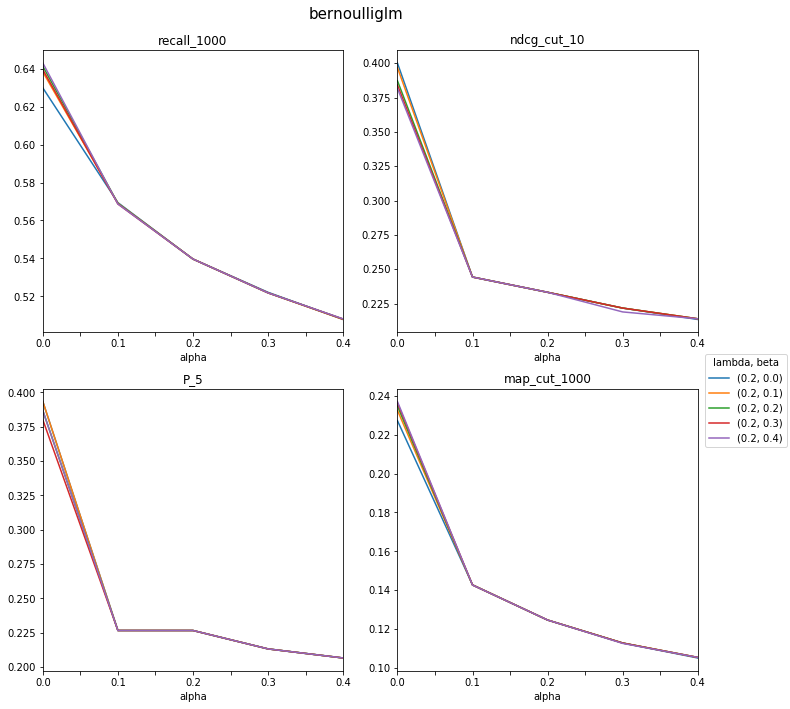

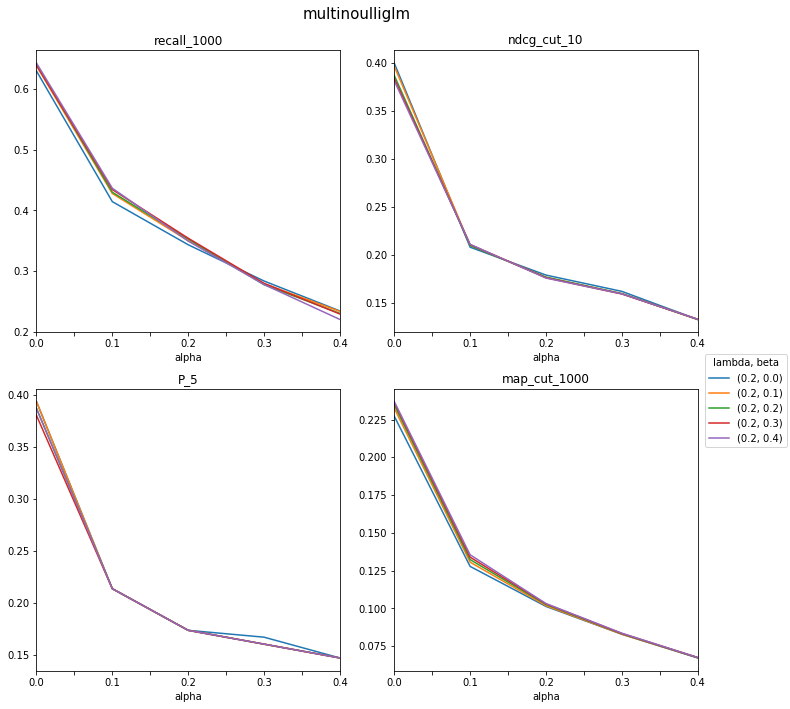

In [40]:
for ind, data in performances3.groupby(level=[0, 1]):
    if ind[1] != '':
        f, axes = plt.subplots(len(data.columns)//2, 2, figsize=(10, 10))
        
        data.index = data.index.droplevel(0)
        
        for i, col in enumerate(data.columns):
            data[col].unstack(level=[0]).unstack(level=[1]).plot(ax=axes[i//2][i%2], legend=False)
            axes[i//2][i%2].set_title(col)
            
        f.legend(title=data.index.names[0] + ', ' + data.index.names[2], bbox_to_anchor=(1.1, 0.5))
        f.tight_layout()
        f.subplots_adjust(hspace=0.2, top=0.92)
        
        f.suptitle(ind[0], size=15)

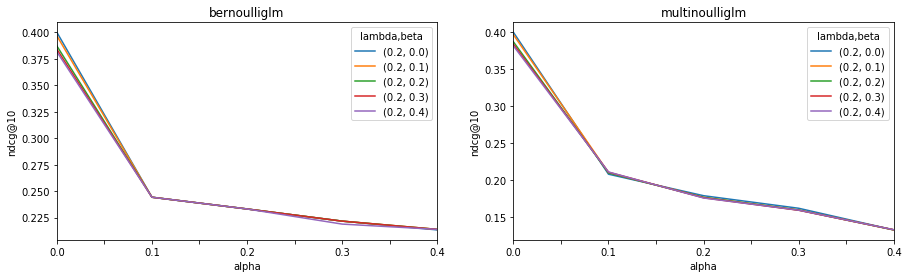

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
i = 0
for ind, data in performances3.groupby(level=[0, 1]):
    if ind[1] != '':
        data.index = data.index.droplevel(0)
        data.unstack(level=[0]).unstack(level=[1])['ndcg_cut_10'].plot(ax=axes[i])
            
            
        axes[i].set_title(ind[0])
        axes[i].set_ylabel('ndcg@10')
        
        i += 1
plt.savefig('task3_params.png', bbox_inches='tight')        

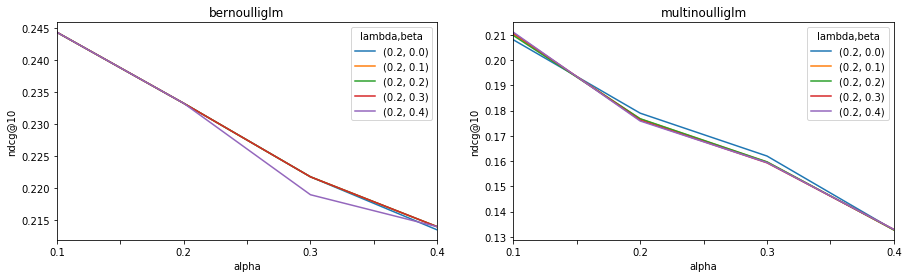

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
i = 0
for ind, data in performances3.query("alpha not in ['0.0']").groupby(level=[0, 1]):
    if ind[1] != '':
        data.index = data.index.droplevel(0)
        data.unstack(level=[0]).unstack(level=[1])['ndcg_cut_10'].plot(ax=axes[i])
            
            
        axes[i].set_title(ind[0])
        axes[i].set_ylabel('ndcg@10')
        
        i += 1

In [50]:
perform_test(task_3, query_performances3, best_ndcg3)

,,,,bernoulliglm,gentfidf,jm,meanglm,multinoulliglm,tfidf
,,,,0.2,,,,0.2,
,,,,0.0,,,,0.0,
,,,,0.0,,,,0.0,
bernoulliglm,0.2,0.0,0.0,-,1,-0.25,1,0,-1
gentfidf,,,,-1,-,-1,-1,-1,-1
jm,,,,0.25,1,-,1,0.25,-0.75
meanglm,,,,-1,1,-1,-,-1,-1
multinoulliglm,0.2,0.0,0.0,0,1,-0.25,1,-,-1
tfidf,,,,1,1,0.75,1,1,-


Using $\beta = 0.4$ in the Generalized Language Models seemed to improve map@1000 w.r.t to JM: the improvement seems to be statistically significant as the next table shows.
The table is similar to the ones before but it considers only the map@1000 measure and use the best parameters on the validation set w.r.t. map@1000. The ones in the column of 'jm' show that the 2 G.L.M.s are significatively better than JM.

In [51]:
perform_test(task_3, query_performances3, validate(performances3, 'map_cut_1000'), measures=['map_cut_1000'])

,,,,bernoulliglm,gentfidf,jm,meanglm,multinoulliglm,tfidf
,,,,0.2,,,,0.2,
,,,,0.0,,,,0.0,
,,,,0.4,,,,0.4,
bernoulliglm,0.2,0.0,0.4,-,1,1,1,0,-1
gentfidf,,,,-1,-,-1,-1,-1,-1
jm,,,,-1,1,-,1,-1,-1
meanglm,,,,-1,1,-1,-,-1,-1
multinoulliglm,0.2,0.0,0.4,0,1,1,1,-,-1
tfidf,,,,1,1,1,1,1,-


In [52]:
test_performances3 = overallPerformancesMultiParams(task_3, 'test', ['lambda', 'alpha', 'beta'])

test_performances3.loc[best_ndcg3.index].style.background_gradient(cmap='viridis', low=.6, high=0, axis=0)

,,,,recall_1000,ndcg_cut_10,P_5,map_cut_1000
model,lambda,alpha,beta,,,,
bernoulliglm,0.2,0.0,0.0,0.6277,0.3646,0.3667,0.1956
gentfidf,,,,0.0201,0.0237,0.0267,0.0072
jm,,,,0.6216,0.3805,0.3717,0.1947
meanglm,,,,0.3987,0.0763,0.0733,0.0429
multinoulliglm,0.2,0.0,0.0,0.6277,0.3646,0.3667,0.1956
tfidf,,,,0.651,0.4169,0.4317,0.2155


# Task 4

#### Logistic Regression

In [ ]:
#baseline Logistic Regression model
lsi = pickle.load(open('lsi_model50.pickle', 'rb'))

In [ ]:
# one of the features
def approximateListMatching(s1, s2, k):
    n = len(s1)
    m = len(s2)
    d = [[],[]]
    
    for i in range(n+1):
        d[0].append(i)
        d[1].append(i)
    
    for j in range(m+1):
        s = max(1, j-m+n-k+1)
        d[(j+1)%2][s-1] = 0
        for i in range(s, n+1):
            if s1[i-1] == s2[j-1]:
                d[(j+1)%2][i] = min(d[j%2][i-1], (0 if i==n else 1) + d[j%2][i])
            else:
                d[(j+1)%2][i] = min(1 + d[j%2][i-1], min((0 if i==n else 1) + d[j%2][i], 1 + d[(j+1)%2][i-1]) )
    
    return d[(m+1)%2][n]

In [ ]:
#features for Learning to Rank
def buildFeatures(query_id, query_terms, int_doc_id, doc_token_ids):
    feature_vector = []

    tot = 0
    for w in query_terms:
        if w in doc_token_ids:
            tot += 1

    feature_vector.append(document_lengths[int_doc_id]) # DOC_LEN
    feature_vector.append(len(query_terms)) # QUERY_LEN
    feature_vector.append(tot) # Q_TERMS in DOC
    feature_vector.append(len(set(query_terms))) # |set(Q_TERMS)|
    feature_vector.append(len(set(doc_token_ids))) # |set(D_TERMS)|
    feature_vector.append(doc_token_ids.count(0)) # STOPWORDS in DOC
    
    tfs = []
    #dfs = []
    tfidfs = []
    
    s_tfidf = 0
    s_bm25 = 0
    s_jm = 0
    s_dirPri = 0
    s_absDis = 0   
    
    for word in query_terms:
        tf = inverted_index[word][int_doc_id] if int_doc_id in inverted_index[word] else 0
        tfs.append(tf)
        # dfs.append(len(inverted_index[word]))
        this_tfidf = tfidf(int_doc_id, word, tf)
        tfidfs.append(this_tfidf)
        
        s_tfidf += this_tfidf
        s_bm25 += bm25(int_doc_id, word, tf)
        s_jm += jm(int_doc_id, word, tf)
        s_dirPri += dirichletPrior(int_doc_id, word, tf)
        s_absDis += absoluteDiscounting(int_doc_id, word, tf)
        
        
    #Compute LSI representations
    q_topics = lsi[[(token_id, doc_token_ids.count(token_id)) for token_id in set(doc_token_ids) if token_id > 0]]
    d_topics = lsi[[(token_id, query_terms.count(token_id)) for token_id in set(query_terms) if token_id > 0]]
    
    # Model Scores
    feature_vector.append(s_tfidf)
    feature_vector.append(s_bm25)
    feature_vector.append(s_jm)
    feature_vector.append(s_dirPri)
    feature_vector.append(s_absDis)
    feature_vector.append(cosine_similarity(q_topics, d_topics)) 
    
    # Minimum editing distance (insert, delete, substitute words) 
    # to document so that the query is a substring of it
    feature_vector.append(approximateListMatching(query_terms, doc_token_ids, 1000))
         
    # TFs
    feature_vector.append(max(tfs))
    feature_vector.append(min(tfs))
    feature_vector.append(np.mean(tfs))
    
    # TF-IDFs
    feature_vector.append(max(tfidfs))
    feature_vector.append(min(tfidfs))
    feature_vector.append(np.mean(tfidfs))
    # feature_vector.append(sum(tfidfs))
    
    #lsi per-topic product
    for t in range(len(q_topics)):
        feature_vector.append(q_topics[t][1] * d_topics[t][1])
          
    
    return np.array(feature_vector)

def build_dataset_logreg(filename, complete=False, save_test=False):
    
    mapping = defaultdict(lambda : defaultdict(lambda : 0))

    with open(filename, 'r') as f:
        for line in f.readlines():
            query_id, _ , ext_doc_id, relevant = line.split()
            int_doc_id = index.document_ids([ext_doc_id])
            if len(int_doc_id) > 0:
                mapping[query_id][int_doc_id[0][1]] = int(relevant)

    dataset = []
    targets = []
    group_lengths = []
    groups = []
    
    for i, (query_id, query_terms) in enumerate(tokenized_queries.items()):
        if i%10==0:
            print(i) 
        length = 0
        for int_doc_id, relevant in mapping[query_id].items(): #docs:

            ext_doc_id, doc_token_ids = index.document(int_doc_id)            
            feature_vector = buildFeatures(query_id, query_terms, int_doc_id, doc_token_ids)
            dataset.append(feature_vector)
            targets.append(relevant)
            groups.append(i)

            length += 1

        if length > 0:    
            group_lengths.append(length)

    dataset = np.array(dataset).reshape(-1, 69)
    targets = np.array(targets)
    return dataset, targets


In [ ]:
# the model is trained on "test file" and tested on "validation file"
test_file = './ap_88_89/qrel_test'
validation_file = './ap_88_89/qrel_validation'
logreg = linear_model.LogisticRegression(class_weight='balanced')
test_dataset_logreg, test_targets_logreg = build_dataset_logreg(test_file)

logreg.fit(test_dataset_logreg, test_targets_logreg) #training

In [ ]:
#test
outdir = './rankings'
model_name = 'logreg'

if not os.path.exists(outdir):
    os.mkdir(outdir)

run_out_path = os.path.join(outdir, '{}.run'.format(model_name))

retrieval_start_time = time.time()

print('Retrieving using', model_name)

data = {}
counter = 0

# Fill the data dictionary: query_id --> [(document_score, external_doc_id), ... , ( , )]
for query_id, query_terms in tokenized_queries.items():
    counter += 1
    if counter % 15 == 0 and counter:
        print(str(counter / num_queries * 100) + "% ...")

    score_per_doc = []

    for int_doc_id in first_1000_dict[query_id]:
        ext_doc_id, doc_token_ids = index.document(int_doc_id)
        
        #build feature vectores for testing
        feature_vec = buildFeatures_logreg(query_id, query_terms, int_doc_id, doc_token_ids)
        
        #use the probability of belonging to class Relevant as score
        score = logreg.predict_proba(feature_vec.reshape(1, -1)).squeeze()[1]
        score_per_doc.append((score, ext_doc_id))

    data[query_id] = score_per_doc

print("Printing results in '" + model_name + ".run'")
with open(run_out_path, 'w') as f_out:
    write_run(
        model_name=model_name,
        data=data,
        out_f=f_out,
        max_objects_per_query=1000)
print('Run retrieval took', time.time() - retrieval_start_time, 'seconds.')

#### RankPy + LambdaMART

In [ ]:
q_ext_tuple = []

# NB: build_features method is the same used in Task 4: Logistic Regression


def build_dataset_rankpy(filename, complete=False, save_test=False):
    '''
    Method to generate the datastructure for the dataset,
    @ returns:
        XGBoost DMatrix representation of dataset
        numpy dataset
        numpy targets
        groups list to group data for query_id
    '''
    
    mapping = defaultdict(lambda : defaultdict(lambda : 0))

    with open(filename, 'r') as f:
        for line in f.readlines():
            query_id, _ , ext_doc_id, relevant = line.split()
            int_doc_id = index.document_ids([ext_doc_id])
            if len(int_doc_id) > 0:
                mapping[query_id][int_doc_id[0][1]] = int(relevant)
        
        
    dataset = []
    targets = []
    group_lengths = []
    groups = []
    

    for i, (query_id, query_terms) in enumerate(tokenized_queries.items()):
        if i%10==0:
            print(i)
            
        length = 0
        
        for int_doc_id, relevant in mapping[query_id].items(): 
            
            ext_doc_id, doc_token_ids = index.document(int_doc_id)
            
            feature_vector = buildFeatures(query_id, query_terms, int_doc_id, doc_token_ids)
            q_ext_tuple.append((query_id, ext_doc_id))
            
            dataset.append(feature_vector)
            targets.append(relevant)
            groups.append(i)

            length += 1

        if length > 0:    
            group_lengths.append(length)

    dataset = np.array(dataset)
    targets = np.array(targets)

    dm_dataset = DMatrix(dataset, label=targets.reshape(-1, 1))

    dm_dataset.set_group(group_lengths)
    
    return dm_dataset, dataset, targets, groups


In [ ]:
# Generate dataset for rankpy
dm_dataset, dataset, targets, groups = build_dataset_rankpy(validation_file, save_test=True)
dm_testset, testset, test_targets, test_groups = build_dataset_rankpy(test_file)

In [ ]:
# Dump dataset to convert it to SVM Light format
dump_svmlight_file(X=dataset, y=targets, f='trainingset', query_id = groups)
dump_svmlight_file(X=testset, y=test_targets, f='testset', query_id = test_groups)

In [ ]:
# Create a relevance mapping for the Gold validation and test files
mapping = defaultdict(lambda : defaultdict(lambda : 0))

with open(test_file, 'r') as f:
    for line in f.readlines():
        query_id, _ , ext_doc_id, relevant = line.split()
        int_doc_id = index.document_ids([ext_doc_id])
        if len(int_doc_id) > 0:
            mapping[query_id][int_doc_id[0][1]] = int(relevant)

with open(validation_file, 'r') as f:
    for line in f.readlines():
        query_id, _ , ext_doc_id, relevant = line.split()
        int_doc_id = index.document_ids([ext_doc_id])
        if len(int_doc_id) > 0:
            mapping[query_id][int_doc_id[0][1]] = int(relevant)            

In [ ]:
# Load the query datasets.
training_queries = Queries.load_from_text('trainingset')
test_queries = Queries.load_from_text('testset')

print('================================================================================')

# Save them to binary format ...
training_queries.save('./data/training')
test_queries.save('./data/test')

# ... because loading them will be then faster.
training_queries = Queries.load('./data/training')
test_queries = Queries.load('./data/test')

print('================================================================================')

# Print basic info about query datasets.
logging.info('Train queries: %s' % training_queries)
logging.info('Test queries: %s' %test_queries)

print('================================================================================')

# Set this to True in order to remove queries containing all documents
# of the same relevance score -- these are useless for LambdaMART.
remove_useless_queries = False

# Find constant query-document features.
cfs = find_constant_features([training_queries, test_queries])

# Get rid of constant features and (possibly) remove useless queries.
training_queries.adjust(remove_features=cfs, purge=remove_useless_queries)
test_queries.adjust(remove_features=cfs)

# Print basic info about query datasets.
print('Train queries: %s' % training_queries)
print('Test queries: %s' % test_queries)

print('================================================================================')

model = LambdaMART(metric='nDCG@10', max_leaf_nodes=7, shrinkage=0.1,
                   estopping=50, n_jobs=-1, min_samples_leaf=500,
                   random_state=42)

# Catch Keyboard Exception to perform early stopping at whatever epoch
try:
    model.fit(training_queries)
except Exception as e:
    print("terminated early")
finally:
    print('================================================================================')

    print('%s on the test queries: %.8f'
             % (model.metric, model.evaluate(test_queries, n_jobs=-1)))

    # Save Model in a file
    model.save('LambdaMART_L7_S0.1_E50_' + model.metric)

In [ ]:
print('%s on the test queries: %.8f'
             % (model.metric, model.evaluate(test_queries, n_jobs=-1)))

In [ ]:
r_dataset = []
r_targets = []
r_list = []
groups = []

# Generate the matrix with the list of pairs document-query to predict scores
for i, (query_id, query_terms) in enumerate(tokenized_queries.items()):

    for int_doc_id in first_1000_dict[query_id]:

        revelant = mapping[query_id][int_doc_id]

        ext_doc_id, doc_token_ids = index.document(int_doc_id)

        feature_vector = buildFeatures(query_id, query_terms, int_doc_id, doc_token_ids)
        
        r_dataset.append(feature_vector)
        r_targets.append(0)
        r_list.append((query_id, ext_doc_id))
        groups.append(i)
        
    if i%10==0:
        print(i)
            
r_dataset = np.array(r_dataset)
r_targets = np.array(r_targets)

In [ ]:
#Transform test queries in svm_light format and compute scores predictions
dump_svmlight_file(X=r_dataset, y=r_targets, f='./data/temp_query', query_id=groups)
this_query = Queries.load_from_text('./data/temp_query')

r_results = model.predict(this_query)

In [ ]:
# create data dictionary to store scores for each query-document pair
data = defaultdict(list)

for i in range(len(r_results)):
    score = r_results[i]
    query_id, ext_doc_id = r_list[i]
    
    data[query_id].append((score, ext_doc_id))
    

In [ ]:
# Save scores in rankpy.run
with open('./rankings/rankpy.run', 'w') as f_out:
    write_run(
        model_name='rankpy',
        data=data,
        out_f=f_out,
        max_objects_per_query=1000)

#### XGBoost + LambdaRank/LambdaMART

In [1]:
# NB: build_features method is the same used in Task 4: Logistic Regression


def build_dataset(filename):
    '''
    Generates the dataset as Pandas Dataframe
    Column Features are named with "f_*" pattern
    '''
    
    mapping = defaultdict(lambda : defaultdict(lambda : 0))

    with open(filename, 'r') as f:
        for line in f.readlines():
            query_id, _ , ext_doc_id, relevant = line.split()
            int_doc_id = index.document_ids([ext_doc_id])
            if len(int_doc_id) > 0:
                mapping[query_id][int_doc_id[0][1]] = int(relevant)
        
        
    dataset = []

    for i, (query_id, query_terms) in enumerate(tokenized_queries.items()):    
        if i % 10 == 0:
            print(i)
        
        for int_doc_id, relevant in mapping[query_id].items():
            
            ext_doc_id, doc_token_ids = index.document(int_doc_id)
            
            feature_vector = buildFeatures(query_id, query_terms, int_doc_id, doc_token_ids)
        
            dataset.append(np.append(feature_vector, [int(relevant), int(query_id), int(int_doc_id)]))

    dataset = pd.DataFrame(dataset)
    cols = dataset.shape[1]
    column_names = ["doc_len","query_len", "query_terms", "set_query_terms","set_doc_terms","doc_stopwords"]
    column_names += ["tf-idf", "bm25", "jm", "dirichlet prior", "absolute discounting", "lsi cosine similarity"]
    column_names += ["approx. list matching", "max(tf)", "min(tf)", "mean(tf)", "max(tf-idfs)", "min(tf-idfs)", "mean(tf-idfs)"]
    column_names = ['f_'+name for name in column_names]
    dataset.columns = column_names + ['f_'+str(i) for i in range(50)] + ['relevance', 'query', 'document']
    
    dataset[['relevance', 'query', 'document']] = dataset[['relevance', 'query', 'document']].astype(int)
    
    
    return dataset

In [ ]:

def get_max_ndcg(k, *ins):
    '''This is a function to get maxium value of DCG@k. That is the DCG@k of sorted ground truth list. '''
    #print ins
    l = [i for i in ins]
    l = copy.copy(l[0])
    l.sort(key=None, reverse=True)
    #print l
    max = 0.0
    for i in range(k):
        max += (math.pow(2, l[i])-1)/math.log(i+2,2)
    return max

def get_ndcg(s, k):
    '''This is a function to get ndcg '''
    z = get_max_ndcg(k, s)
    dcg = 0.0
    for i in range(k):
        dcg += (math.pow(2, s[i])-1)/math.log(i+2,2)
    if z==0:
        z = 1;
    ndcg = dcg/z
    #print "Line:%s, NDCG@%d is %f with DCG = %f, z = %f"%(s, k, ndcg,dcg, z)
    return ndcg

# Generate representation using XGBoost DMatrix
def to_DMatrix(data, features, target):
    dm = DMatrix(data[features], label=data[target], feature_names=features)
    dm.set_group(data.groupby('query').size().values)
    return dm

# Evaluate a model on some test data returning the average ndcg
def evaluate(model, data, features, target):
    data_dm = to_DMatrix(data, features=features, target=target)
    prediction = pd.DataFrame(data[['query', 'relevance']])
    prediction['prediction'] = -1*model.predict(data_dm)

    prediction.sort_values(['query', 'prediction'], inplace=True)

    
    mean = 0
    
    for query_id, relevances in prediction.groupby('query')['relevance']:
        ndcg = get_ndcg(list(relevances.values), 10)
        #print(query_id, ndcg)
        mean += ndcg
    return mean / len(prediction.groupby('query'))

In [ ]:
def kfold_cv(dataset, features, target, params, K=10):
    '''
    Compute training using 10-fold cross-validation
    returns the average ndcg
    '''
    
    kf = KFold(n_splits=K)

    queries = dataset['query'].unique()
    
    avg_ndcg = 0
    
    for train_queries, test_queries in kf.split(queries):
        test_queries = queries[test_queries]
        train_queries = queries[train_queries]
        
        train = dataset[dataset['query'].isin(train_queries)]
        test = dataset[dataset['query'].isin(test_queries)]
        
        train_dm = to_DMatrix(train, features=features, target=target)
        test_dm = to_DMatrix(test, features=features, target=target)

        model = xgb.train(params, train_dm, num_boost_round=params['n_estimators'], evals=[(test_dm, 'test'), (train_dm, 'train')], verbose_eval=False)

        avg_ndcg += evaluate(model, test, features=features, target=target)

        del train_dm
        del test_dm

    avg_ndcg /= K
    return avg_ndcg
    

In [ ]:
testset = build_dataset(validation_file)
dataset = build_dataset(test_file)

In [ ]:
features = [col for col in dataset if col.startswith('f_')]
target = 'relevance'

In [ ]:
verbose = True

def tune_and_update(param_test, parameters, tune_score):
    '''
    Function to tune parameters (1 or 2 at a time) using gridsearch
    @ returns
        best_score achieved in the tuning step
        updated optimal_parameters
        tune_score starting from previous optimal score
    '''
    temp_params = parameters.copy()
    params = parameters.copy()
    best_params = {}
    best_score = float('-inf')
    param_list = list(param_test.items())
    
    if len(param_list) == 1:
        par_1 = param_list[0][1]
        for p in par_1:
            temp_params.update({param_list[0][0]: p})
            score = kfold_cv(dataset, features=features, target=target, params = temp_params)
            if score > best_score:
                best_score = score
                best_params = temp_params.copy()
                print("\t",{param_list[0][0]: p}, "\t BEST", best_score)
            else:
                print("\t",{param_list[0][0]: p})
    elif len(param_list) == 2:
        par_1 = param_list[0][1]
        par_2 = param_list[1][1]
        for p in par_1:
            temp_params.update({param_list[0][0]: p})
            print("\t",{param_list[0][0]: p})
            for p2 in par_2:
                temp_params.update({param_list[1][0]: p2})
                score = kfold_cv(dataset, features=features, target=target, params = temp_params)
                if score > best_score:
                    best_score = score
                    best_params = temp_params.copy()
                    print("\t\t",{param_list[1][0]: p2},"\t BEST", best_score)
                else:
                    print("\t\t",{param_list[1][0]: p2})
    else:
        print("Too many param combinations, max 2 types of parameter each time")
    
    if best_score > tune_score:
        tune_score = best_score
        params.update(best_params)
        tuning.append((params.copy(), best_score))
        print("Finished test, IMPROVED best_score =", tune_score)
    else:
        print("Finished test, nothing new...")
        
    return best_score, params, tune_score

In [ ]:
#Compute gridsearch over all hyperparameters of a model

def parameter_gridsearch(params):    
    tuning = []
    testing = []
    tune_score = float('-inf')
    start_time = time.time()

    test_ndcg = kfold_cv(dataset, features=features, target=target, params = params)
    if verbose:
        print('First Model\tTesting avg_ndcg = ' + str(test_ndcg) + ' time: ' + str(time.time() - start_time) + '\n')
    testing.append((params.copy(), test_ndcg))


    #Beginning parameter Tuning

    params['n_estimators'] = 50


    param_test1 = {
             'max_depth': list(range(3, 10, 2)),
             'min_child_weight': list(range(1, 6, 2))
            }

    sc, params, tune_score = tune_and_update(param_test1, params, tune_score)
    if verbose:
        print('Tuning 1\tScore = ' + str(sc))

    param_test2 = {
     'max_depth':[params['max_depth'] + k for k in [-1, 0, 1] if params['max_depth'] + k > 0],
     'min_child_weight': [params['min_child_weight'] + k for k in [-1, 0, 1] if params['min_child_weight'] + k > 0]
    }

    sc, params, tune_score = tune_and_update(param_test2, params, tune_score)
    if verbose:
        print('Tuning 2\tScore = ' + str(sc))


    param_test2b = {
     'min_child_weight':[6,8,10,12]
    }
    sc, params, tune_score = tune_and_update(param_test2b, params, tune_score)
    if verbose:
        print('Tuning 2b\tScore = ' + str(sc))


    #Try and evaluating the method with parameters tuned until now
    tmp_par = params.copy()
    tmp_par.update({'n_estimators' : 100})
    test_ndcg = kfold_cv(dataset, features=features, target=target, params = tmp_par)
    if verbose:
        print ('Second model\tTesting ndcg = ' + str(test_ndcg) + ' time: ' + str(time.time() - start_time) + '\n')
    testing.append((tmp_par, test_ndcg))

    #Continue tuning

    param_test3 = {
     'gamma':[i/10.0 for i in range(0,5)]
    }
    sc, params, tune_score = tune_and_update(param_test3, params, tune_score)
    if verbose:
        print('Tuning 3\tScore = ' + str(sc))

    #Try and evaluating the method with parameters tuned until now
    tmp_par = params.copy()
    tmp_par.update({'n_estimators' : 100})
    test_ndcg = kfold_cv(dataset, features=features, target=target, params = tmp_par)
    if verbose:
        print ('Third Model\tTesting ndcg = ' + str(test_ndcg) + ' time: ' + str(time.time() - start_time) + '\n')
    testing.append((tmp_par, test_ndcg))

    #Continue tuning

    param_test4 = {
     'subsample':[i/10.0 for i in range(6,10)],
     'colsample_bytree':[i/10.0 for i in range(6,10)]
    }

    sc, params, tune_score = tune_and_update(param_test4, params, tune_score)
    if verbose:
        print('Tuning 4\tScore = ' + str(sc))

    ss = int(params['subsample']*100)
    csbt = int(params['colsample_bytree']*100)
    param_test5 = {
     'subsample':[i/100.0 for i in range(max(0, ss-10), ss+5,5)],
     'colsample_bytree':[i/100.0 for i in range(max(0, csbt-10), csbt+5,5)]
    }
    sc, params, tune_score = tune_and_update(param_test5, params, tune_score)
    if verbose:
        print('Tuning 5\tScore = ' + str(sc))

    param_test6 = {
     'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
    }
    sc, params, tune_score = tune_and_update(param_test6, params, tune_score)
    if verbose:
        print('Tuning 6\tScore = ' + str(sc))

    if 'reg_alpha' in params:
        a = math.log10(params['reg_alpha'])
    else:
        a = 0
    param_test7 = {
     'reg_alpha':[0] + np.logspace(a-2, a+1, num=4) 
    }

    sc, params, tune_score = tune_and_update(param_test7, params, tune_score)
    if verbose:
        print('Tuning 7\tScore = ' + str(sc))


    param_test8 = {
        'n_estimators' : [10, 100, 1000, 2000],
        'learning_rate': [0.005, 0.01, 0.05, 0.1]
    }

    sc, params, tune_score = tune_and_update(param_test8, params, tune_score)
    if verbose:
        print('Tuning 8\tScore = ' + str(sc))

    #Try and evaluating the method with parameters tuned until now
    tmp_par = params.copy()
    tmp_par.update({'n_estimators' : 100})
    test_ndcg = kfold_cv(dataset, features=features, target=target, params = tmp_par)
    if verbose:
        print ('Fourth model\tTesting ndcg = ' + str(test_ndcg) + ' time: ' + str(time.time() - start_time) + '\n')
    testing.append((tmp_par, test_ndcg))

    param_test9 = {
        'n_estimators' : [30, 40, 50, 60, 70],
        'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.5]
    }

    sc, params, tune_score = tune_and_update(param_test9, params, tune_score)
    if verbose:
        print('Tuning 9\tScore = ' + str(sc))

    # Evaluate the final Model

    test_ndcg = kfold_cv(dataset, features=features, target=target, params = params)
    if verbose:
        print ('Final model\tTesting ndcg = ' + str(test_ndcg) + ' time: ' + str(time.time() - start_time) + '\n')
    testing.append((params.copy(), test_ndcg))
    
    return params, tuning, testing

In [ ]:
# Creates and returns a model with a certain parameter configuration to be used for prediction
def create_model(dataset, features, target, params, K=10):

    queries = dataset['query'].unique()
    train = dataset[dataset['query'].isin(queries)]
    train_dm = to_DMatrix(train, features=features, target=target)

    model = xgb.train(params, train_dm, num_boost_round=params['n_estimators'], verbose_eval=False)

    return model

In [ ]:
# Compute prediction scores with the model created on the test set 
#(actually the validation set, as we used the test set to train)
def predict_and_output(xgb_model, model_name)
    data = defaultdict(list)

    for i, (query_id, query_terms) in enumerate(tokenized_queries.items()):

        for int_doc_id in first_1000_dict[query_id]:
            ext_doc_id, doc_token_ids = index.document(int_doc_id)

            this_features = buildFeatures(query_id, query_terms, int_doc_id, doc_token_ids)
            feature_vector = DMatrix(this_features.reshape(1,-1), feature_names=features)
            score = xgb_model.predict(feature_vector)

            data[query_id].append((score[0], ext_doc_id))

        if i%10==0:
            print(i)

    # Output results on model_name.run
    with open('./rankings/'+model_name+'.run', 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)
    return

In [ ]:
# Initial parameters for XGBoost
# rank:pairwise uses Basic Pairwise Rank
# rank:ndcg uses LambdaMART

#Params for Basic Pairwise Rank
params = {
    'learning_rate' : 0.1,
    'n_estimators' : 100,
    'max_depth' : 5,
    'min_child_weight' : 1,
    'gamma' : 0,
    'subsample' : 0.8,
    'colsample_bytree' : 0.8,
    'objective' : 'rank:pairwise', # 'rank:ndcg' for LambdaMART
    'nthread' : 4,
    'n_jobs' : 7,
    'eval_metric' : ['ndcg@10', 'map@1000'],
    'scale_pos_weight' : 1,
    #'seed' : 27
}

# Params for LambdaMART
params_MART = params.copy()
params_MART.update({'objective' : 'rank:ndcg'})

In [ ]:
# Create models with the initial params
xgb_initial_model = create_model(dataset, features=features, target=target, params=params)
xgb_initial_model_MART = create_model(dataset, features=features, target=target, params=params_MART)

In [ ]:
# Builds the models for Basic Pairwise and LambdaMART with optimal parameter obtained in tuning phase
params, tuning, testing = parameter_gridsearch(params)
xgb_best_params = tuning[-1][0].copy()
xgb_model = create_model(dataset, features=features, target=target, params=xgb_best_params)

params_MART, tuning_MART, testing_MART = parameter_gridsearch(params_MART)
xgb_best_params_MART = tuning_MART[-1][0].copy()
xgb_model_MART = create_model(dataset, features=features, target=target, params=xgb_best_params_MART)

In [ ]:
# Compute predictions and output results in *.run
predict_and_output(xgb_initial_model, "BasicPairwiseInit")
predict_and_output(xgb_initial_model_MART, "BasicPairwiseBest")
predict_and_output(xgb_model, "LambdaMARTInit")
predict_and_output(xgb_model_MART, "LambdaMARTBest")

In [ ]:
#Print f-scores for all of the features taken into account by
#XGBoost when creating the model
xgb_model.get_fscore()

## Analysis

N.B.: Since we have trained on the "test set", now we test on the "validation set"

In [14]:
task_4 = ['tfidf'] + ['logreg', 'BasicPairwiseBest', 'BasicPairwiseInit', 'LambdaMARTBest', 'LambdaMARTInit', 'rankpy']

performances on the "testset" (i.e. the one used for training)

In [9]:
performances4, best_ndcg4 = overallPerformances(task_4, 'test')

best_ndcg4.style.background_gradient(cmap='viridis', low=.7, high=0, axis=0)

,,,recall_1000,ndcg_cut_10,P_5,map_cut_1000
model,parameter,parameter_value,,,,
BasicPairwiseBest,,-1.0,0.651,0.4459,0.445,0.2172
BasicPairwiseInit,,-1.0,0.651,0.59,0.6017,0.2936
LambdaMARTBest,,-1.0,0.651,0.5835,0.6267,0.274
LambdaMARTInit,,-1.0,0.651,0.5288,0.5517,0.2543
logreg,,-1.0,0.651,0.2083,0.2017,0.1352
rankpy,n,220.0,0.651,0.0708,0.0767,0.0453
tfidf,,-1.0,0.651,0.4169,0.4317,0.2155


Now we use the "validation set" as the "test set"

In [12]:
query_performances4 = queriesPerfomrmances(task_4, 'evaluations')
perform_test(task_4, query_performances4, best_ndcg4)

,,,BasicPairwiseBest,BasicPairwiseInit,LambdaMARTBest,LambdaMARTInit,logreg,rankpy,tfidf
,,,,,,,,n,
,,,-1.0,-1.0,-1.0,-1.0,-1.0,220.0,-1.0
BasicPairwiseBest,,-1.0,-,0,0,0,0.75,0.75,0
BasicPairwiseInit,,-1.0,0,-,0,0,0.5,0.75,0
LambdaMARTBest,,-1.0,0,0,-,0,0.75,0.75,-0.25
LambdaMARTInit,,-1.0,0,0,0,-,0.5,0.75,0
logreg,,-1.0,-0.75,-0.5,-0.75,-0.5,-,0.75,-0.75
rankpy,n,220.0,-0.75,-0.75,-0.75,-0.75,-0.75,-,-0.75
tfidf,,-1.0,0,0,0.25,0,0.75,0.75,-


In [13]:
test_performances4, _ = overallPerformances(task_4, 'evaluations')
test_performances4.loc[best_ndcg4.index].style.background_gradient(cmap='viridis', low=.6, high=0, axis=0)

,,,recall_1000,ndcg_cut_10,P_5,map_cut_1000
model,parameter,parameter_value,,,,
BasicPairwiseBest,,-1.0,0.6712,0.3401,0.36,0.2194
BasicPairwiseInit,,-1.0,0.6712,0.3656,0.3533,0.2153
LambdaMARTBest,,-1.0,0.6712,0.3351,0.3333,0.2167
LambdaMARTInit,,-1.0,0.6712,0.3413,0.3467,0.2165
logreg,,-1.0,0.6712,0.2251,0.2067,0.1782
rankpy,n,220.0,0.6712,0.0648,0.0533,0.0519
tfidf,,-1.0,0.6712,0.3672,0.3667,0.2403
